# Progetto di Machine Learning 2023

Il presente progetto riguarda la predizione dei prezzi delle case.

In [1]:
import matplotlib.pyplot as plt
import sm as sm
from pandas import Series, DataFrame

from feature_selection import *
from model_selection import *
from models import *
from grafici import *
from dataset import *
import pandas as pd
import numpy as np
import seaborn as sns
from typing import List, Tuple, Dict, Any
from pprint import pprint


In [2]:
from sklearn.model_selection import train_test_split

initial_training_set = pd.read_csv('../dataset/train.csv')

In [3]:
print(initial_training_set.shape)
print(initial_training_set.columns)

(1460, 81)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

Suddividiamo le colonne in numeriche e categoriche:

In [4]:
numerical_cols = initial_training_set.select_dtypes(include='number').columns.to_list()
numerical_train = initial_training_set[numerical_cols]
print(numerical_cols)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [5]:
categorical_cols = initial_training_set.select_dtypes(include='object').columns.to_list()
categorical_train = initial_training_set[categorical_cols]
print(categorical_cols)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


# 1. Data Exploration

Sono state confrontate tutte le feature con il target. Per i dettagli fare riferimento ai file dataset/valutazioneFeatures.csv e valutazioneFeatures.ipynb.

## 1.1 Matrice di correlazione

Le feature più importanti sono le seguenti:

C:\Users\emeli\AppData\Local\Temp\ipykernel_2140\509050092.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df_train.corr()


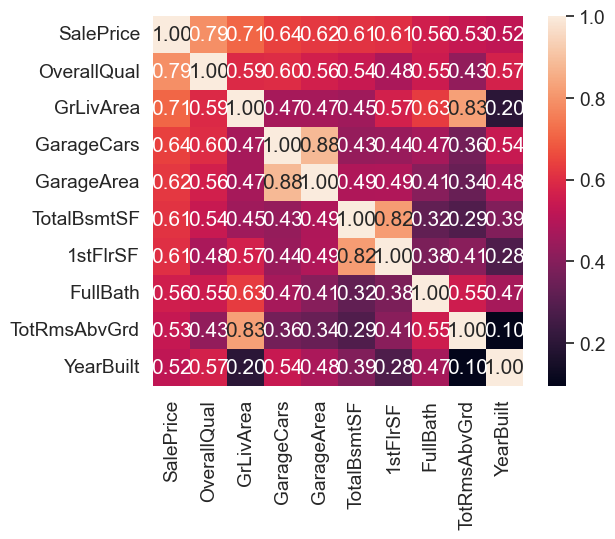

In [6]:
def correlation_matrix_plot(df_train: DataFrame, k=10):
    # saleprice correlation matrix
    corrmat = df_train.corr()
    cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
    cm = np.corrcoef(df_train[cols].values.T)
    sns.set(font_scale=1.25)
    sns.heatmap(cm,
                cbar=True,  # mostra la legenda a destra
                annot=True,  # mostra i valori nelle celle
                square=True,  # se True mostra il grafico come un quadrato
                fmt='.2f',  # formatta il numero di cifre decimali delle 'annot'
                yticklabels=cols.values,  # mostra le label dell'asse y
                xticklabels=cols.values  # mostra le label dell'asse x
                )
    plt.show()


correlation_matrix_plot(initial_training_set, k=10)

Analizziamo la heatmap:
- Sulla diagonale c'è sempre 1 perché le features sono in correlazione con loro stesse.
- La feature più importante è **OverallQual** con correlazione 0.79 rispetto al SalePrice.
- Garage Cars e Garage Area sono molto correlate tra loro, quindi si può mantenere solamente quella che è più correlata con il SalePrice, ovvero **GarageCars**.
- TotRmsAbvGrd e GrLivArea sono anche loro molto correlate tra loro, la più importante però è **GrLivArea**.
- 1stFlrSF è correlata con **TotalBsmtSF**, ma è più importante quest'ultima.

Per essere più precisi, visualizziamo la heatmap con le sole feature che hanno valore di correlazione con almeno un altra feature superiore a una certa soglia.

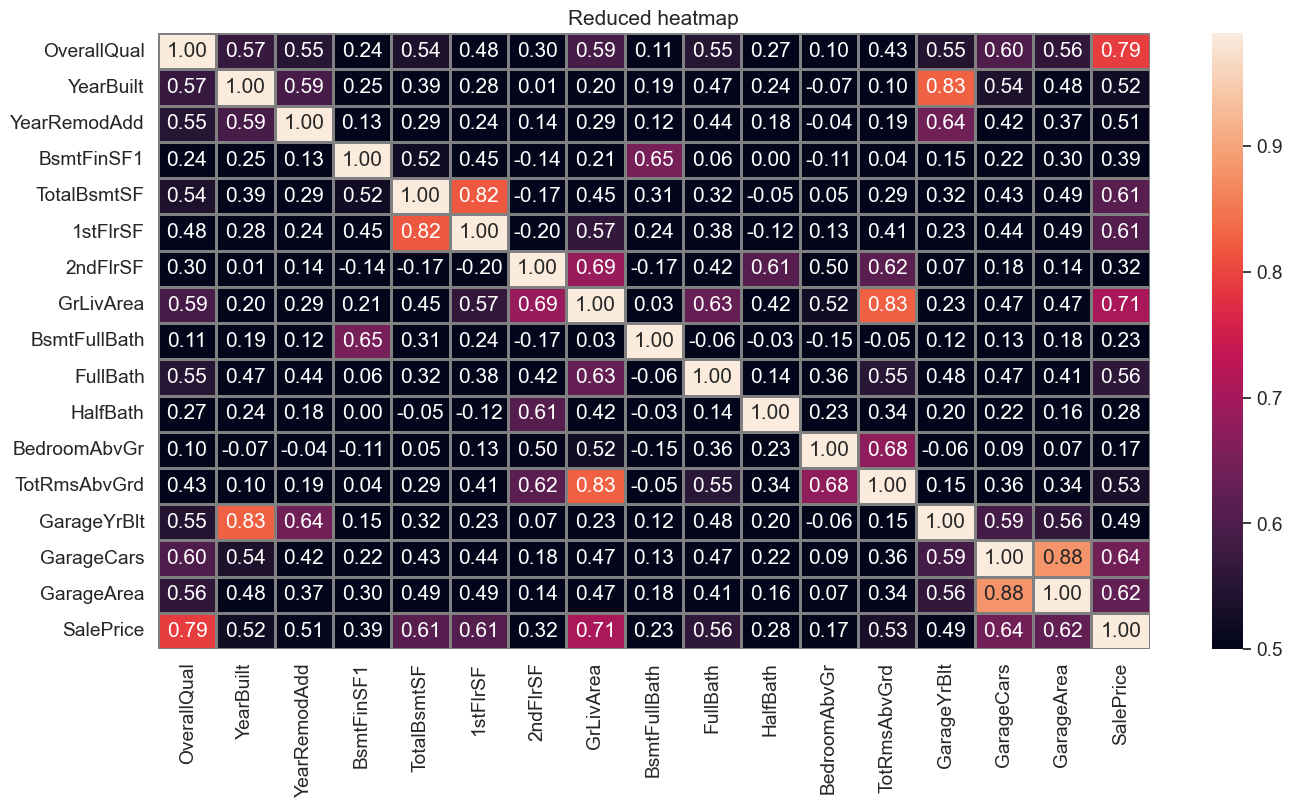

In [7]:
def correlazione_matrice(df_train: DataFrame, threshold: float, val_max: float):
    """Calcola la matrice di correlazione (ndarray) a partire da un dataframe di feature tutte numeriche"""
    corr = df_train.corr().to_numpy()
    # seleziona gli elementi che sono compresi tra il threshold e un valore massimo
    ind_x, = np.where(np.all(np.logical_or(corr < threshold, corr > val_max), axis=0))
    corr = np.delete(corr, ind_x, 1)  # si eliminano

    # stessa cosa per le righe
    ind_y, = np.where(np.all(np.logical_or(corr < threshold, corr > val_max), axis=1))
    corr = np.delete(corr, ind_y, 0)
    # si aggiornano le colonne selezionando solamente quelle filtrate

    return corr, ind_x, ind_y


def correlation_matrix_filtered_plot(df_train: DataFrame, threshold=0.6):
    # threshold: valore minimo di correlazione da considerare
    val_max = 0.99
    # si selezionano le colonne
    labels = df_train.columns
    corr, ind_x, ind_y = correlazione_matrice(df_train, threshold, val_max)
    # si aggiornano le colonne selezionando solamente quelle filtrate
    map_labels_x = [item for i, item in enumerate(labels) if i not in ind_x]
    map_labels_y = [item for i, item in enumerate(labels) if i not in ind_y]
    # plot heatmap
    plt.figure(figsize=(16, 8))
    heatmap = sns.heatmap(corr, annot=True, fmt='.2f',
                          xticklabels=map_labels_x,
                          yticklabels=map_labels_y,
                          vmin=threshold,
                          vmax=val_max,
                          linewidths=1.0,
                          linecolor="grey")

    heatmap.set_title("Reduced heatmap")
    plt.show()


correlation_matrix_filtered_plot(numerical_train, 0.5)

Ora troviamo le coppie feature con correlazione maggiore di 0.6 e prendiamo anche il valore di correlazione di ciascuna con il SalePrice:

In [8]:
def correlazione_dataframe(df_train, threshold, val_max):
    # si selezionano le colonne
    labels = df_train.columns

    corr, ind_x, ind_y = correlazione_matrice(df_train, threshold, val_max)
    map_labels_x = [item for i, item in enumerate(labels) if i not in ind_x]
    map_labels_y = [item for i, item in enumerate(labels) if i not in ind_y]

    return pd.DataFrame(corr, columns=map_labels_x, index=map_labels_y)


class Correlazione:
    def __init__(self, feature1, feature2, correlazione, correlazione_f1_target, correlazione_f2_target):
        self.feature1 = feature1
        self.feature2 = feature2
        self.correlazione = correlazione
        self.correlazione_f1_target = correlazione_f1_target
        self.correlazione_f2_target = correlazione_f2_target

    def __str__(self):
        return f"({self.feature1, self.feature2, self.correlazione, self.correlazione_f1_target, self.correlazione_f2_target})"

    def __repr__(self):
        return f"({self.feature1, self.feature2, self.correlazione, self.correlazione_f1_target, self.correlazione_f2_target})"

    def __gt__(self, other):
        return self.correlazione > other.correlazione

    def __lt__(self, other):
        return self.correlazione < other.correlazione


def feature_in_correlazione(corr: DataFrame, thresh: float) -> List[Correlazione]:
    colonne = corr.columns
    corr_list = []
    target_index = len(colonne) - 1
    # per ogni riga del dataframe della matrice di correlazione
    for (i, r) in enumerate(corr):
        # e per ogni colonna
        for (j, c) in enumerate(corr[r]):
            # se una coppia di feature diverse ha correlazione elevata, la aggiungiamo alla lista
            if c > thresh and i != j and colonne[i] != "SalePrice" and colonne[j] != "SalePrice":
                # calcoliamo la correlazione delle due feature con la colonna target
                corr_f1_target = corr.iloc[i, target_index]
                corr_f2_target = corr.iloc[j, target_index]
                corr_list.append(Correlazione(colonne[i], colonne[j], c, corr_f1_target, corr_f2_target))

    corr_list.sort()
    return corr_list


min_correlation = 0.6
# trasformo la matrice di correlazione di tutto il dataset in un dataframe
corr = correlazione_dataframe(numerical_train, min_correlation, 0.99)
# poi stampo la lista di feature in correlazione
feature_correlate = feature_in_correlazione(corr, min_correlation)
pprint(feature_correlate)

[(('OverallQual', 'GarageCars', 0.6006707165907149, 0.7909816005838053, 0.6404091972583519)),
 (('GarageCars', 'OverallQual', 0.6006707165907149, 0.6404091972583519, 0.7909816005838053)),
 (('2ndFlrSF', 'HalfBath', 0.6097073002717436, 0.31933380283206736, 0.28410767559478256)),
 (('HalfBath', '2ndFlrSF', 0.6097073002717436, 0.28410767559478256, 0.31933380283206736)),
 (('2ndFlrSF', 'TotRmsAbvGrd', 0.6164226354915431, 0.31933380283206736, 0.5337231555820284)),
 (('TotRmsAbvGrd', '2ndFlrSF', 0.6164226354915431, 0.5337231555820284, 0.31933380283206736)),
 (('GrLivArea', 'FullBath', 0.6300116462511148, 0.7086244776126515, 0.5606637627484453)),
 (('FullBath', 'GrLivArea', 0.6300116462511148, 0.5606637627484453, 0.7086244776126515)),
 (('YearRemodAdd', 'GarageYrBlt', 0.6422767797035356, 0.5071009671113866, 0.4863616774878596)),
 (('GarageYrBlt', 'YearRemodAdd', 0.6422767797035356, 0.4863616774878596, 0.5071009671113866)),
 (('BsmtFinSF1', 'BsmtFullBath', 0.6492117535742649, 0.386419806242153

Quindi troviamo le feature che hanno correlazione maggiore con il SalePrice:

In [9]:
best_features = set()
worst_features = set()
for c in feature_correlate:
    c: Correlazione = c
    if c.correlazione_f1_target > c.correlazione_f2_target:
        best_features.add((c.feature1, c.correlazione_f1_target))
        worst_features.add(c.feature2)
    else:
        best_features.add((c.feature2, c.correlazione_f2_target))
        worst_features.add(c.feature1)

best_features_list = list(best_features)
worst_features_list = list(worst_features)
best_features_list.sort(key=lambda x: x[1], reverse=True)
pprint(best_features_list)
print("feature correlate con altre: ", worst_features_list)

[('OverallQual', 0.7909816005838053),
 ('GrLivArea', 0.7086244776126515),
 ('GarageCars', 0.6404091972583519),
 ('TotalBsmtSF', 0.6135805515591943),
 ('TotRmsAbvGrd', 0.5337231555820284),
 ('YearBuilt', 0.5228973328794967),
 ('YearRemodAdd', 0.5071009671113866),
 ('BsmtFinSF1', 0.3864198062421535),
 ('2ndFlrSF', 0.31933380283206736)]
feature correlate con altre:  ['HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageCars', 'GarageYrBlt', 'FullBath', '2ndFlrSF', 'GarageArea', '1stFlrSF', 'BsmtFullBath']


## 1.2 Distribuzione normale

Confrontiamo le feature migliori che hanno un'alta correlazione con il valore target:


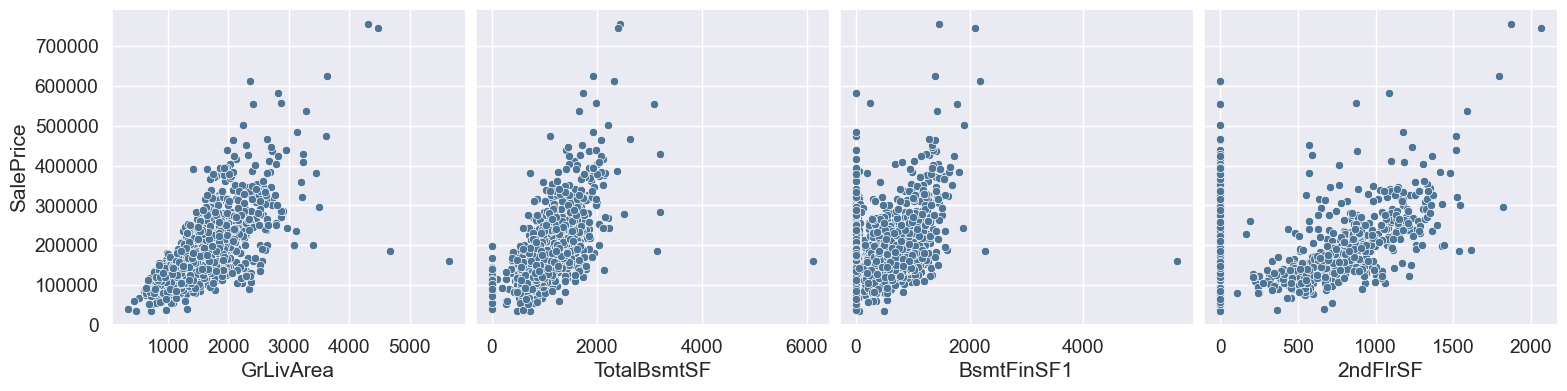

In [10]:
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta',
          'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue',
          'xkcd:scarlet']

features_pair_plot = ['GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', '2ndFlrSF']
sns.pairplot(initial_training_set, x_vars=features_pair_plot, y_vars="SalePrice", height=4, diag_kind='kde',
             plot_kws=dict(color=colors[8]),
             diag_kws=dict(fill=True, alpha=.7, color=colors[0]))

Sembrerebbe che le feature abbiano un andamento lineare.

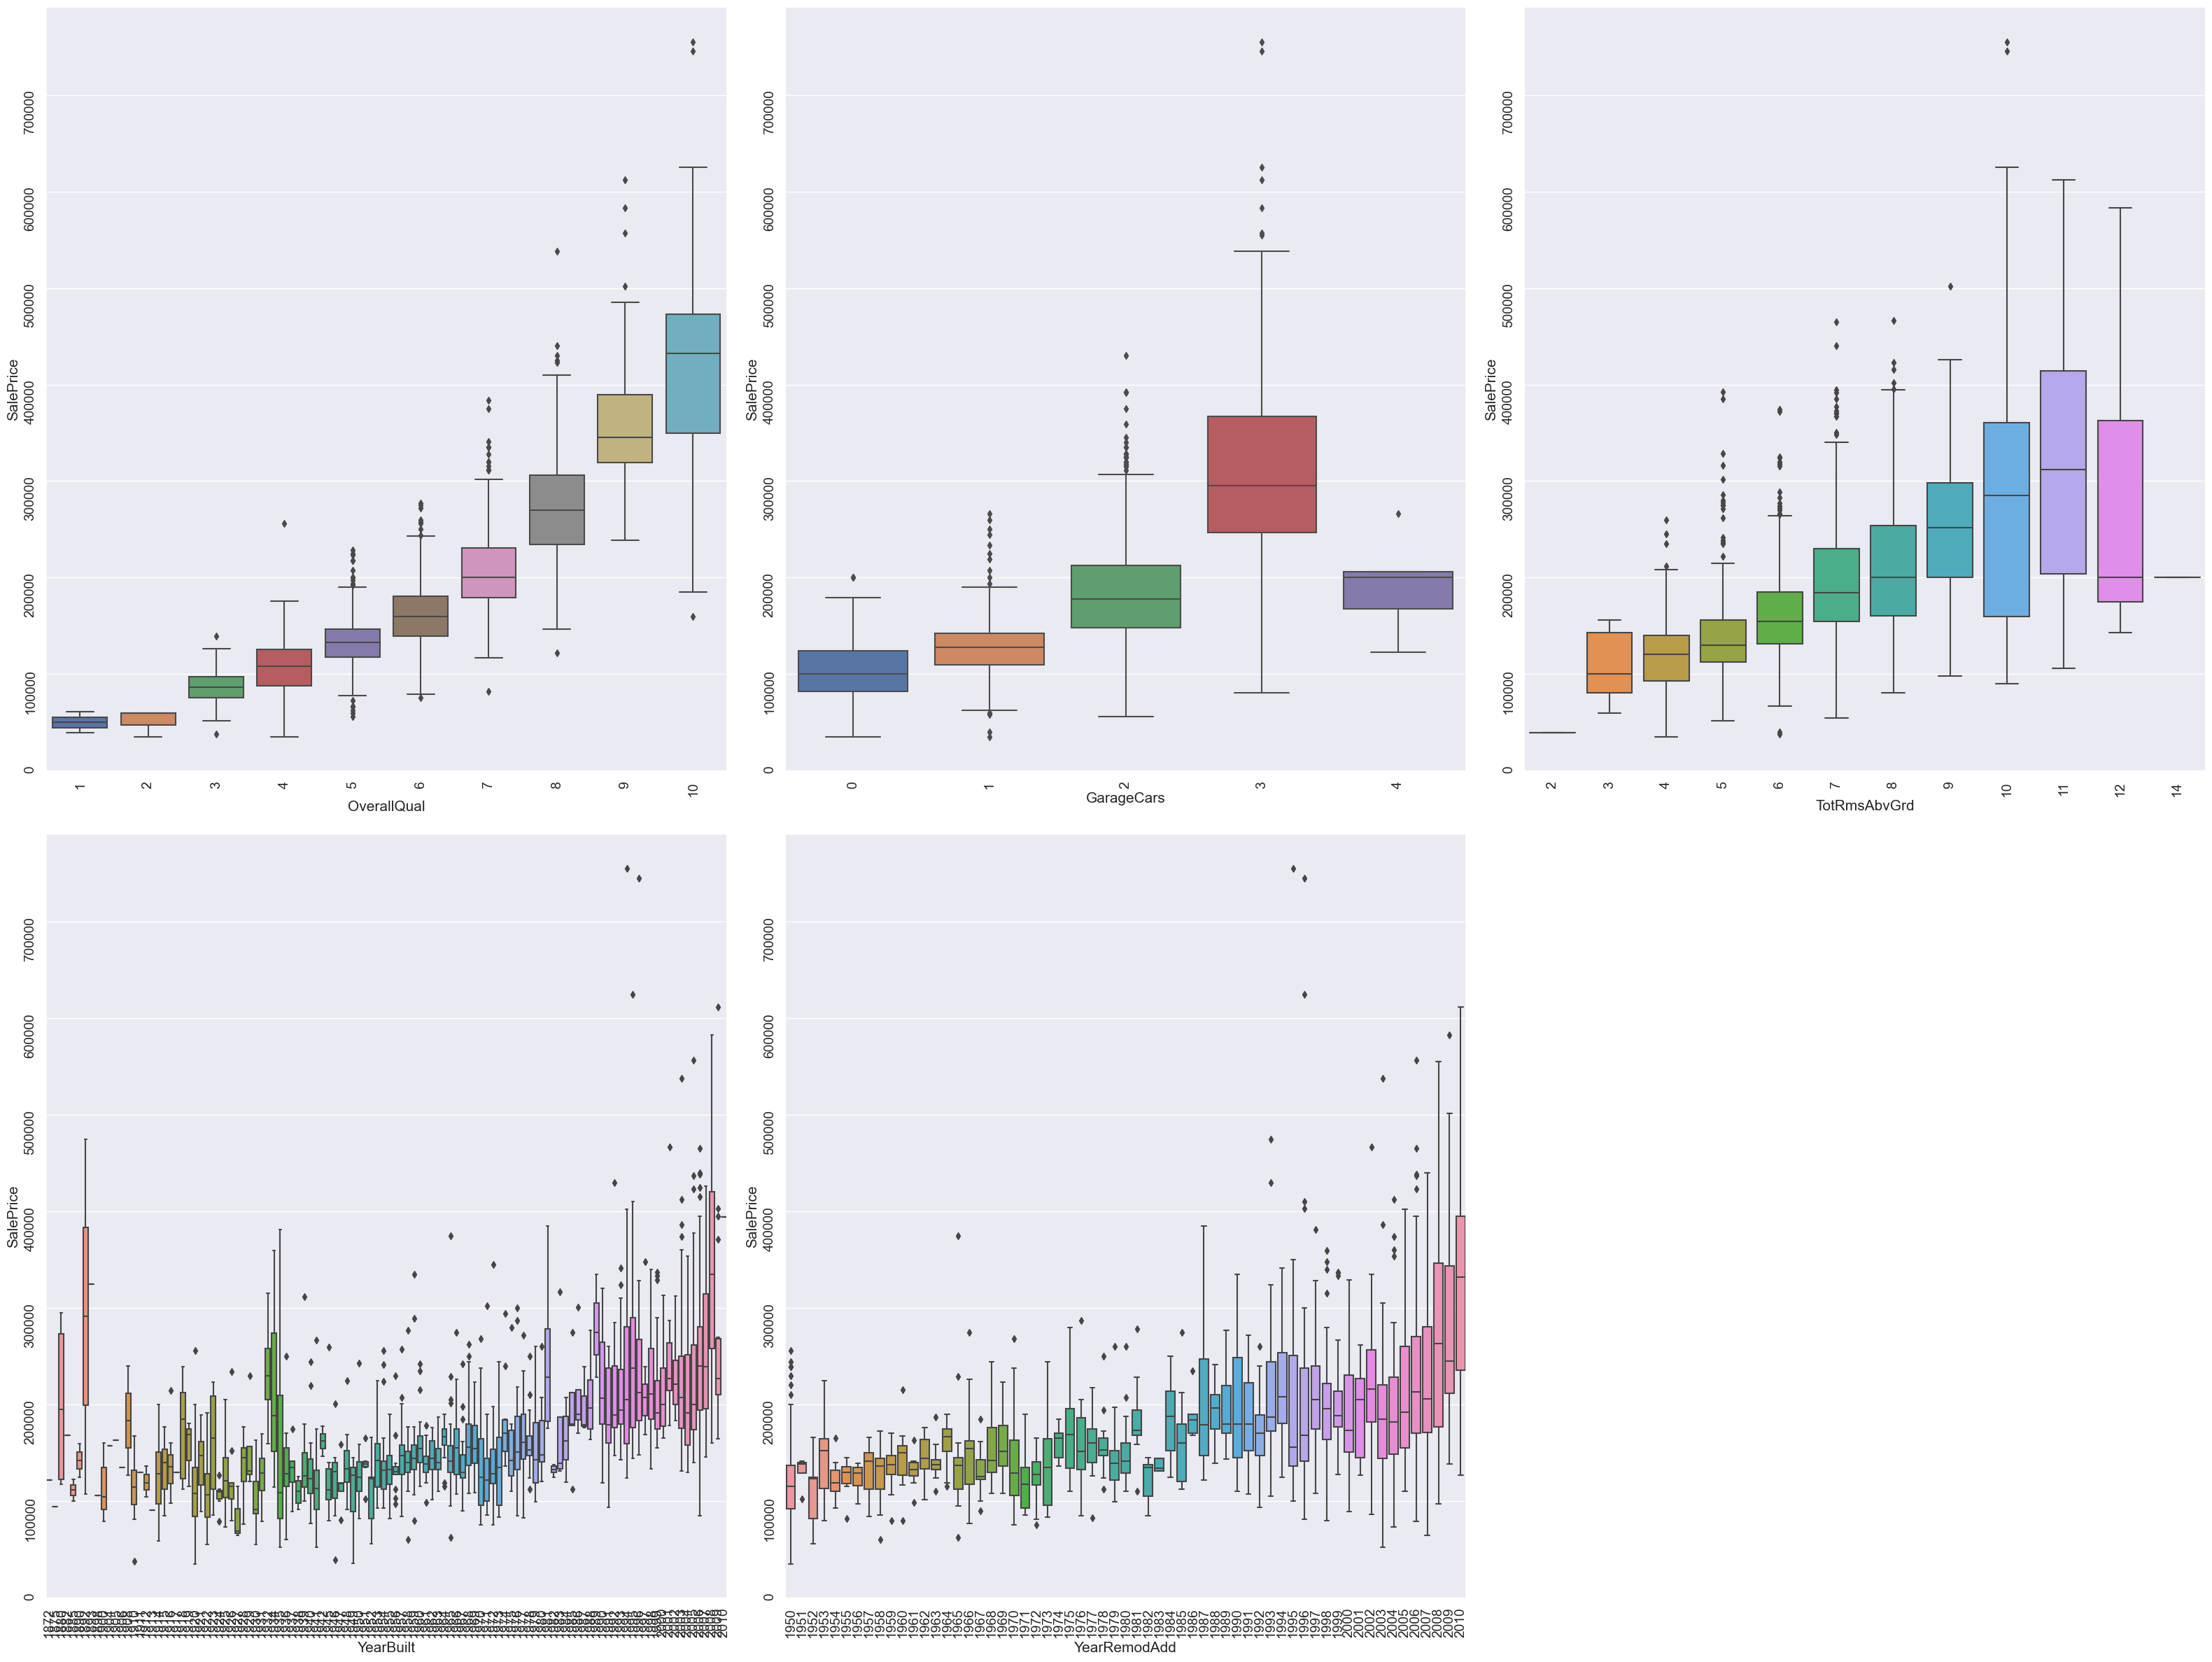

In [11]:
features_box_plot = ['OverallQual', 'GarageCars', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']

axis_x = 0
axis_y = 0
fig, axes = plt.subplots(2, 3, figsize=(32, 24))
for fbp in features_box_plot:
    f = sns.boxplot(ax=axes[axis_x, axis_y], data=initial_training_set, x=fbp, y='SalePrice')
    f.axis(ymin=0, ymax=800000)
    axes[axis_x, axis_y].tick_params(rotation=90)
    axes[axis_x, axis_y].autoscale(enable=True)
    fig.tight_layout()
    if axis_y == 2:
        axis_x = 1
        axis_y = 0
    else:
        axis_y += 1

fig.delaxes(axes[axis_x][2])

Possiamo notare che *'OverallQual'* influisce molto sul prezzo, infatti all'aumentare della qualità aumenta anche il prezzo delle case; mentre, sulle altre feature non influisce molto come la prima.

Studiamo se le feature hanno una distribuzione normale.

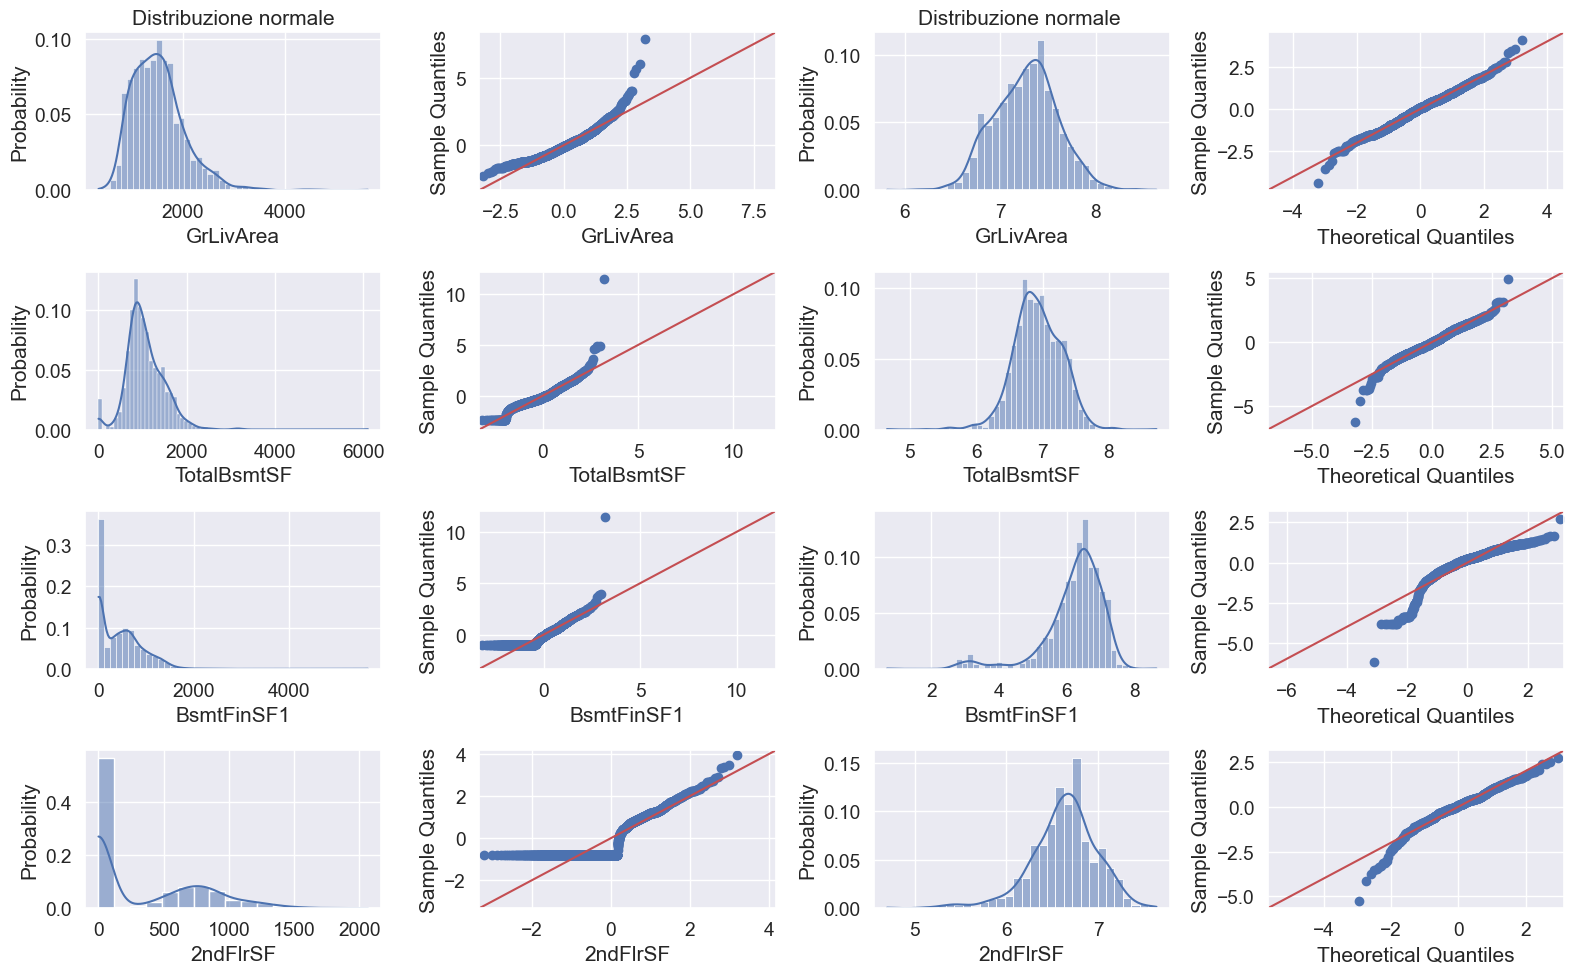

In [12]:
import statsmodels.api as sm


def distribution_plot(train_df: DataFrame, features: str):
    fig, axes = plt.subplots(features.__len__(), 4, figsize=(16, 10))
    axis = 0
    for feature in features:
        sns.histplot(ax=axes[axis, 0], data=train_df, x=feature, kde=True, stat="probability")
        sm.qqplot(ax=axes[axis, 1], data=train_df[feature], line='45', fit=True)
        # in questo caso si considerano valori > 0
        sns.histplot(ax=axes[axis, 2], data=np.log(train_df[train_df[feature] > 0][feature]),
                     kde=True, stat="probability")
        sm.qqplot(ax=axes[axis, 3], data=np.log(train_df[train_df[feature] > 0][feature]), line='45', fit=True)
        axes[0, 0].set_title("Distribuzione normale")
        axes[0, 2].set_title("Distribuzione normale ")
        axes[axis, 0].set_xlabel(feature)
        axes[axis, 1].set_xlabel(feature)
        plt.tight_layout()
        axis += 1


distribution_plot(initial_training_set, features_pair_plot)

E' possibile notare che in:
- **'GrLiveArea'**, ci sono più outliers, rispetto agli altri, e non si ha una distribuzione normale. Effettuando la trasformazione dei dati attraverso una *trasformazione log* si ottiene una distribuzione normale.

# 2. Data cleaning
Analizziamo il dataset per eliminare i valori nulli. In particolare adottiamo la seguente politica:
- se i valori nulli sono maggiori del 80% degli elementi del training set, eliminiamo la feature.
- altrimenti, se la feature è numerica, sostituiamo il valore nullo con il valore medio.
- altrimenti, se la feature è categorica, sostituiamo il valore nullo con il valore più comune.

Questo passaggio è necessario per il corretto funzionamento dei metodi di feature selection, feature extraction e per i modelli di machine learning che utilizzeremo.

## 2.1 Rimozione delle colonne con molti valori nulli
Innanzitutto realizziamo un grafico con le features che hanno almeno un valore nullo:

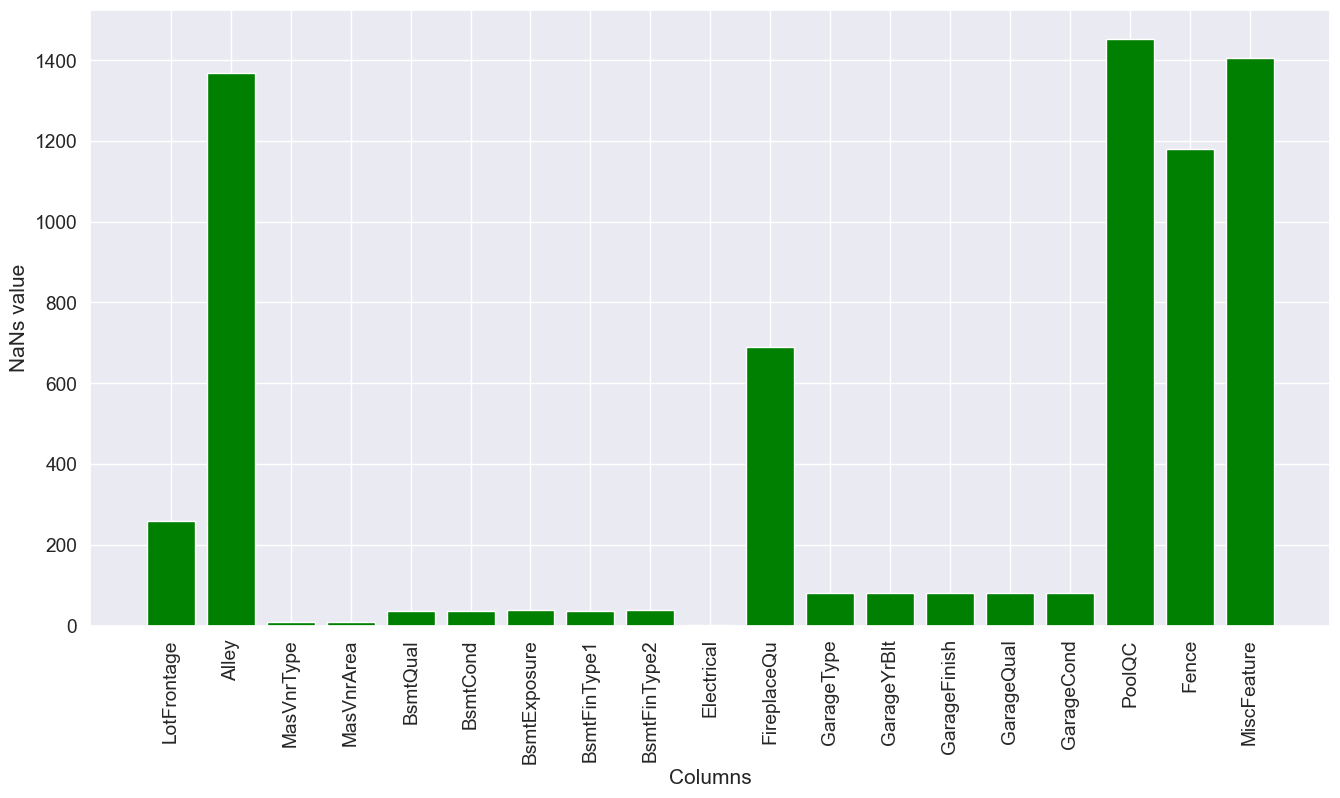

Colonne con valori nulli:  19


In [13]:
def get_nan_cols(dataset: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Index]:
    """ Restituisce:
        0: un dataframe con nome colonna, numero null
        1: una lista (Index) con i nomi delle colonne che hanno valori nulli
    """
    count_nan = dataset.isnull().sum(axis=0)
    columns_with_nan_df = count_nan.loc[count_nan != 0]
    nan_cols_names = dataset.columns[dataset.isna().any()]
    return columns_with_nan_df, nan_cols_names


def get_cols_with_nan_number(dataset: pd.DataFrame):
    print("Colonne con valori nulli: ", len(get_nan_cols(dataset)[1].to_list()))


def check_nan_value(dataset):
    # Verifichiamo se ci sono valori NaN
    columns_with_nan_df, nan_cols_names = get_nan_cols(dataset)
    pd.DataFrame(data=nan_cols_names)
    plt.figure(figsize=(16, 8))
    plt.bar(nan_cols_names, columns_with_nan_df, color="green")
    plt.xlabel("Columns")
    plt.xticks(rotation=90)
    plt.ylabel("NaNs value")
    plt.show()


check_nan_value(initial_training_set)
get_cols_with_nan_number(initial_training_set)

Notiamo che ci sono 19 colonne che hanno almeno un valore nullo. In particolare: **Alley**, **PoolQC**, **Fence** e **MiscFeature** hanno più dell'85% di valori nulli, quindi le **eliminiamo**

Numero di valori non nulli minimo:  293


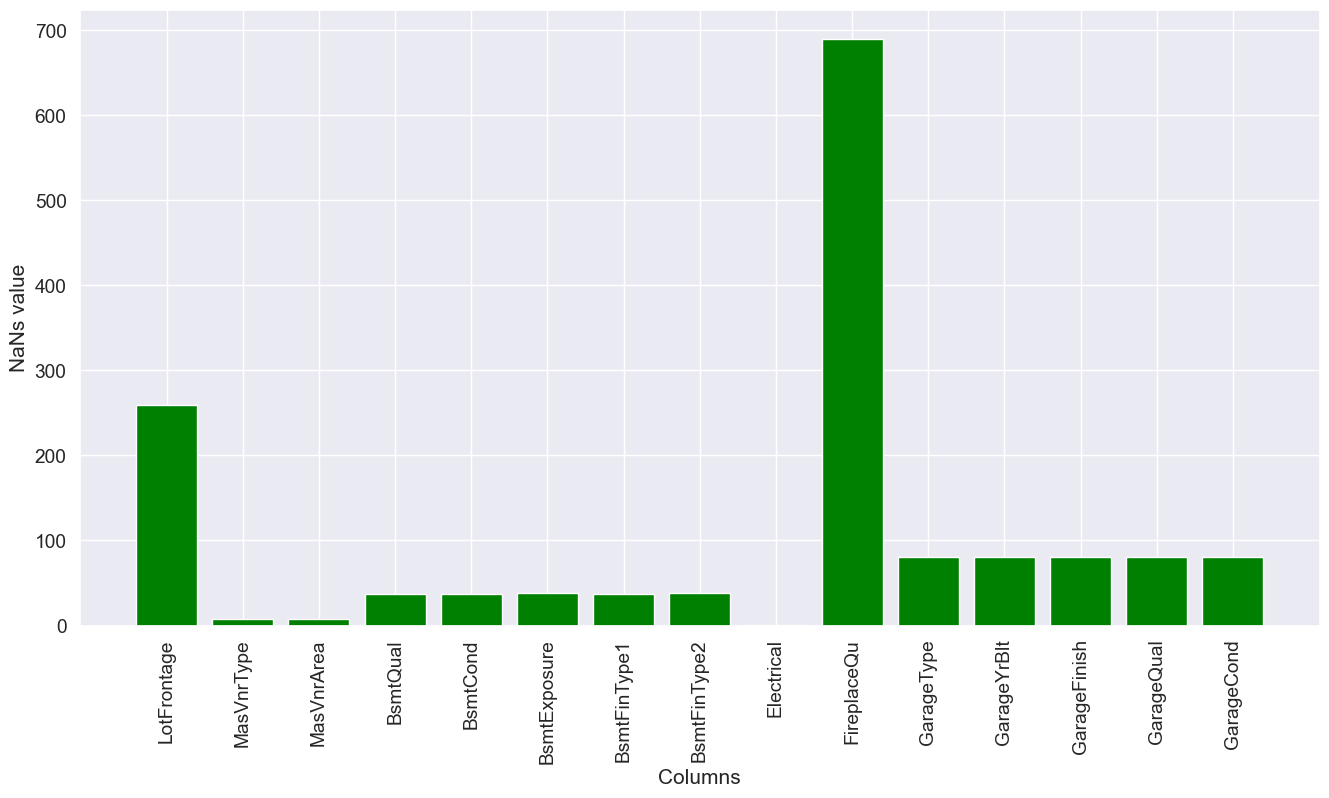

Colonne con valori nulli:  15


In [14]:
def remove_nan_columns(dataset: DataFrame, threshold=20) -> DataFrame:
    """Elimina colonne con valori NaN quando i valori Nan sono superiori a [threshold]%"""
    thresh = int((len(dataset) * threshold) / 100) + 1
    print("Numero di valori non nulli minimo: ", thresh)
    # axis: specifichiamo di eliminare solo le colonne; thresh: numero minimo per eliminare
    dataset.dropna(axis='columns', thresh=thresh, inplace=True)
    return dataset


initial_training_set2 = remove_nan_columns(initial_training_set)
check_nan_value(initial_training_set2)  # senza troppi valori nulli
get_cols_with_nan_number(initial_training_set2)

## 2.2 Sostituzione dei valori nulli nelle feature numeriche

Consideriamo le colonne numeriche dopo aver eliminato le colonne con valori NaN:


In [15]:
numerical_cols = initial_training_set2.select_dtypes(include='number').columns.to_list()
numerical_train = initial_training_set2[numerical_cols]
print(numerical_cols)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


L'Id non ci serve, quindi lo togliamo:

In [16]:
if len(numerical_cols) > 0 and numerical_cols[0] == 'Id':
    del numerical_cols[0]
numerical_train = numerical_train.drop(['Id'], axis=1, errors='ignore')
initial_training_set2 = initial_training_set2.drop(['Id'], axis=1, errors='ignore')

Sostituiamo alle colonne numeriche del training set `initial_training_set2` a cui abbiamo eliminato le colonne con oltre l'80% dei valori nulli, la media dei valori al posto dei rimanenti valori NaN

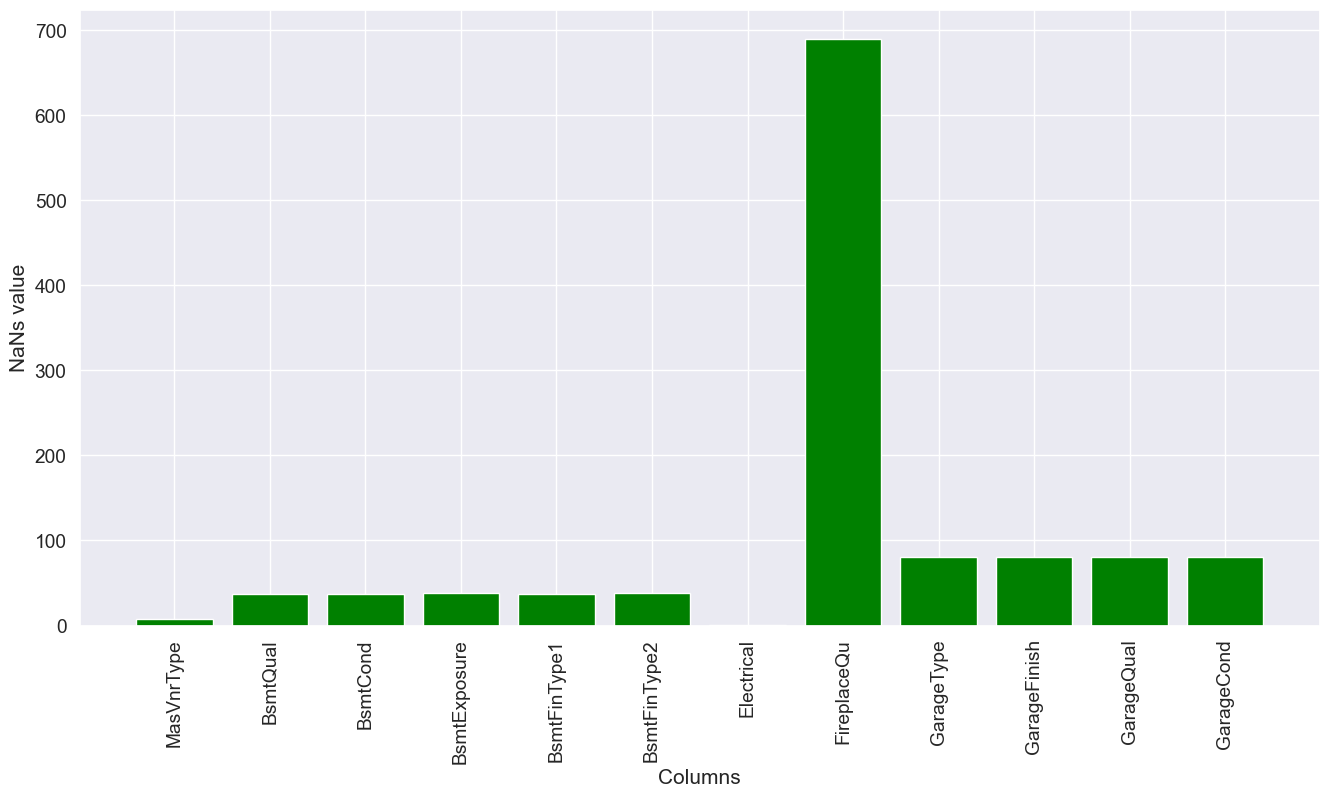

Colonne con valori nulli:  12
      MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0             60       RL         65.0     8450   Pave      Reg         Lvl   
1             20       RL         80.0     9600   Pave      Reg         Lvl   
2             60       RL         68.0    11250   Pave      IR1         Lvl   
3             70       RL         60.0     9550   Pave      IR1         Lvl   
4             60       RL         84.0    14260   Pave      IR1         Lvl   
...          ...      ...          ...      ...    ...      ...         ...   
1455          60       RL         62.0     7917   Pave      Reg         Lvl   
1456          20       RL         85.0    13175   Pave      Reg         Lvl   
1457          70       RL         66.0     9042   Pave      Reg         Lvl   
1458          20       RL         68.0     9717   Pave      Reg         Lvl   
1459          20       RL         75.0     9937   Pave      Reg         Lvl   

     Utilities LotCon

In [17]:
initial_training_set2 = initial_training_set2.fillna(initial_training_set2[numerical_cols].mean())
check_nan_value(initial_training_set2)  # senza troppi valori nulli
get_cols_with_nan_number(initial_training_set2)
print(initial_training_set2)

## 2.3 Sostituzione dei valori nulli nelle feature categoriche

Per prima cosa prendiamo le colonne categoriche

In [18]:
categorical_cols = initial_training_set2.select_dtypes(include='object').columns.to_list()
categorical_train = initial_training_set2[categorical_cols]
print(categorical_cols)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


Sostituiamo alle colonne **categoriche** del training set `initial_training_set2` a cui abbiamo eliminato le colonne con oltre l'80% dei valori nulli e i valori nulli delle colonne numeriche, la moda dei valori al posto dei rimanenti valori NaN.

In [19]:
mode = categorical_train.mode()
print(f"Valori più frequenti\n{mode.iloc[0]}\n\n")
initial_training_set2 = initial_training_set2.fillna(mode.iloc[0])
get_cols_with_nan_number(initial_training_set2)

Valori più frequenti
MSZoning              RL
Street              Pave
LotShape             Reg
LandContour          Lvl
Utilities         AllPub
LotConfig         Inside
LandSlope            Gtl
Neighborhood       NAmes
Condition1          Norm
Condition2          Norm
BldgType            1Fam
HouseStyle        1Story
RoofStyle          Gable
RoofMatl         CompShg
Exterior1st      VinylSd
Exterior2nd      VinylSd
MasVnrType          None
ExterQual             TA
ExterCond             TA
Foundation         PConc
BsmtQual              TA
BsmtCond              TA
BsmtExposure          No
BsmtFinType1         Unf
BsmtFinType2         Unf
Heating             GasA
HeatingQC             Ex
CentralAir             Y
Electrical         SBrkr
KitchenQual           TA
Functional           Typ
FireplaceQu           Gd
GarageType        Attchd
GarageFinish         Unf
GarageQual            TA
GarageCond            TA
PavedDrive             Y
SaleType              WD
SaleCondition     Normal
Name

# 2. Preprocessing
Trasformiamo tutte le colonne categoriche in numeriche.
- Se la colonna categorica rappresenta una valutazione, usiamo l'ordinal encoding
- Altrimenti usiamo one-hot encoding (one-of-k). In tal caso le feature aumenteranno quindi bisogna controllare il numero di colonne finale.

Per prima cosa determiniamo le colonne categoriche che vanno trasformate con l'**ordinal encoding** e quelle che vanno trasformate con l'one hot encoding, a partire dal file `valutazioneFeature.csv`.

In [20]:
ordinal_enc_cols = [
    "ExterQual",
    "KitchenQual",
    "ExterCond",
    "HeatingQC",
    "BsmtCond",
    "BsmtFinType1",
    "BsmtFinType2",
    "GarageCond",
    "BsmtExposure",
    "GarageQual",
    "FireplaceQu",
    "BsmtQual"
]

onehot_enc_cols = [
    "MSZoning",
    "Condition1",
    "Electrical",
    "Functional",
    "Utilities",
    "Condition2",
    "Exterior1st",
    "BldgType",
    "CentralAir",
    "Exterior2nd",
    "Heating",
    "HouseStyle",
    "RoofMatl",
    "Street",
    "LotConfig",
    "Neighborhood",
    "LandSlope",
    "Foundation",
    "LandContour",
    "MasVnrType",
    "PavedDrive",
    "RoofStyle",
    "SaleType",
    "GarageFinish",
    "GarageType",
    "LotShape",
    "SaleCondition"
]

## 3.1 Ordinal encoding

Eseguiamo prima l'ordinal encoding:

In [21]:
def ordinal_encoding(dataset: DataFrame, ord_enc_cols: List[str]) -> DataFrame:
    # applica l'ordinal Encoding alle colonne categoriche che rappresentano una valutazione
    copy = dataset.copy()
    for cat in ord_enc_cols:
        copy[cat], _ = pd.factorize(dataset[cat])

    return copy


initial_training_set3 = ordinal_encoding(initial_training_set2, ordinal_enc_cols)

print("Alcune delle colonne prima e dopo l'ordinal encoding")
print(initial_training_set2[ordinal_enc_cols[:3]])
print(initial_training_set3[ordinal_enc_cols[:3]])

Alcune delle colonne prima e dopo l'ordinal encoding
     ExterQual KitchenQual ExterCond
0           Gd          Gd        TA
1           TA          TA        TA
2           Gd          Gd        TA
3           TA          Gd        TA
4           Gd          Gd        TA
...        ...         ...       ...
1455        TA          TA        TA
1456        TA          TA        TA
1457        Ex          Gd        Gd
1458        TA          Gd        TA
1459        Gd          TA        TA

[1460 rows x 3 columns]
      ExterQual  KitchenQual  ExterCond
0             0            0          0
1             1            1          0
2             0            0          0
3             1            0          0
4             0            0          0
...         ...          ...        ...
1455          1            1          0
1456          1            1          0
1457          2            0          1
1458          1            0          0
1459          0            1          

## 3.2 One hot encoding

Ora eseguiamo il one hot encoding. Il numero iniziale di colonne è:

In [22]:
initial_training_set3.shape[1]

76

In [23]:
def one_hot_encoding(dataset: DataFrame, one_hot_cols: List[str]) -> DataFrame:
    """
    Mappa le features categoriche in nuove colonne in formato one-hot
    :param dataset: self.train o self.test
    :return: il DataFrame di train o test con le stringhe trasformate in ulteriori colonne one-hot (con i nomi)
    """

    copy = dataset.copy()

    # applica il One Hot Encoding alle colonne categoriche
    encoded_df = pd.get_dummies(dataset[one_hot_cols])

    # aggiunge il prefisso al nome delle colonne
    prefix_dict = {col: f"{col}_{val}" for col in one_hot_cols for val in dataset[col].unique()}

    encoded_df.add_prefix('').rename(columns=prefix_dict)

    only_non_one_hot = copy.drop(columns=one_hot_cols, axis=1)
    result_df = pd.concat([only_non_one_hot, encoded_df], axis=1)

    return result_df


initial_training_set4 = one_hot_encoding(initial_training_set3, one_hot_cols=onehot_enc_cols)
initial_training_set4.to_csv("../dataset/train_encoded.csv", index=False)
print(initial_training_set4.shape[1])

231


Notiamo che il numero di colonne è passato da 76 a 231. Quindi in seguito sarà necessario determinare quali colonne sono più informative rispetto alla variabile target SalePrice.

Prima di andare avanti, eliminiamo queste feature molto correlate tra loro:

In [24]:
initial_training_set5 = initial_training_set4.drop(columns=worst_features_list, axis=1)
print(len(initial_training_set4.columns))
print(len(initial_training_set5.columns))

231
221


Abbiamo quindi ridotto il numero di colonne da 231 a 221 (compreso il target).

# 3. Shuffle e suddivisione training - testing set

In [25]:
initial_training_shuffle = initial_training_set5.sample(frac=1, random_state=42).reset_index(drop=True)

In [26]:
initial_X = initial_training_shuffle.iloc[:,
            initial_training_shuffle.columns != 'SalePrice']  # tutte le colonne tranne l'ultima
initial_y = pd.Series(initial_training_shuffle["SalePrice"], name="SalePrice")  # solo l'ultima colonna
X_train, X_test, y_train, y_test = train_test_split(initial_X, initial_y, test_size=0.2, random_state=42)

print(f"shape train X: {X_train.shape}")
print(f"shape train y: {y_train.shape}")
print(f"shape test X: {X_test.shape}")
print(f"shape test y: {y_test.shape}")

print(X_train)

shape train X: (1168, 220)
shape train y: (1168,)
shape test X: (292, 220)
shape test y: (292,)
      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
254           20    70.049958    11553            5            5       1968   
1066          20    60.000000     8072            5            5       1994   
638           70   144.000000    21384            5            6       1923   
799           50    70.049958    13650            5            5       1958   
380           20    71.000000     9187            6            5       1983   
...          ...          ...      ...          ...          ...        ...   
1095          20    70.000000    10150            5            5       1958   
1130          60    70.000000     8462            6            5       1994   
1294          80    80.000000     9600            6            6       1955   
860           60    70.049958    28698            5            5       1967   
1126          60    63.000000     7

Definiamo una funzione per normalizzare i dati, per migliorare l'accuratezza dei modelli

In [27]:
def scale_features(X_df, y_train=None, scaler=StandardScaler()):
    if y_train is not None:
        res = scaler.fit_transform(X_df, y_train)
    else:
        res = scaler.transform(X_df)
    return pd.DataFrame(res, columns=X_df.columns)

Usiamo il metodo seguente per suddividere il training set iniziale in diversi train/test set sulla base della cross validation

In [28]:
class Dataset:
    """
    Classe che definisce il nostro dataset, separato in training e testing set, 
    normalizzato o meno e con o senza feature selection. Va inizializzato con un solo fold (es. 80/20)
    """

    def __init__(self, X_train: DataFrame, y_train: Series, X_test: DataFrame, y_test: DataFrame,
                 scaler=StandardScaler()):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_train_normalized = None
        self.X_test_normalized = None
        self.X_train_fs = None
        self.X_test_fs = None
        self.scaler = scaler
        self.scale_features()

    def check_ok(self, initial_size):
        return self.X_train.shape[0] + self.X_test.shape[0] == initial_size

    def scale_features(self):
        self.X_train_normalized = scale_features(self.X_train, self.scaler)
        self.X_test_normalized = scale_features(self.X_test, self.scaler)


dataset = Dataset(X_train, y_train, X_test, y_test)

In [29]:
class Fold:
    def __init__(self, fold_id: int, X_train: DataFrame, y_train: Series, X_test: DataFrame, y_test: DataFrame,
                 scaler=StandardScaler()):
        self.fold_id = fold_id
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_train_normalized = None
        self.X_test_normalized = None
        self.X_train_normalized_fs = None
        self.X_test_normalized_fs = None
        self.scaler = scaler
        self.scale_features()

    def check_ok(self, initial_size):
        return self.X_train.shape[0] + self.X_test.shape[0] == initial_size

    def print_shapes(self):
        print(f"{self.fold_id} shape x train: {self.X_train.shape} " +
              f"{self.fold_id} shape y train: {self.y_train.shape} " +
              f"{self.fold_id} shape x test : {self.X_test.shape} " +
              f"{self.fold_id} shape y test : {self.y_test.shape}")

    def scale_features(self):
        self.X_train_normalized = scale_features(self.X_train, self.scaler)
        self.X_test_normalized = scale_features(self.X_test, self.scaler)


def split_dataset(initial_dataset_x, initial_y, splits=10) -> List[Fold]:
    lista: List[Fold] = []
    n_elements = len(initial_dataset_x)
    for split in range(splits):
        # dataset: |-1-|-2-|...|-10-|
        if split == 0:  # training: |-2-10| testing: |-1-|
            f = Fold(fold_id=split,
                     X_train=initial_dataset_x.iloc[(n_elements // splits):, :],
                     y_train=initial_y[(n_elements // splits):],
                     X_test=initial_dataset_x.iloc[:(n_elements // splits), :],
                     y_test=initial_y[:(n_elements // splits)])
            lista.append(f)
        elif split == n_elements - 1:  # training: |-1-9| testing: |-10-|
            f = Fold(fold_id=split,
                     X_train=initial_dataset_x.iloc[:split *
                                                     (n_elements // splits), :],
                     y_train=initial_y[:split * (n_elements // splits)],
                     X_test=initial_dataset_x.iloc[split *
                                                   (n_elements // splits):, :],
                     y_test=initial_y[split * (n_elements // splits):])
            lista.append(f)
        else:  # training: |-1-i||(i+1)-10| testing: |-i-(i+1)-|
            before_test_x = initial_dataset_x.iloc[:split * (n_elements // splits), :]
            after_test_x = initial_dataset_x.iloc[(split + 1) * (n_elements // splits):, :]

            x_train_appended: DataFrame = pd.concat([before_test_x, after_test_x])
            before_test_y = initial_y[:split * (n_elements // splits)]
            after_test_y = initial_y[(split + 1) * (n_elements // splits):]
            y_train_appended = pd.concat([before_test_y, after_test_y])

            lista.append(Fold(fold_id=split,
                              X_train=x_train_appended,
                              y_train=y_train_appended,
                              X_test=initial_dataset_x.iloc[split * (n_elements // splits):(
                                                                                                   split + 1) * (
                                                                                                   n_elements // splits),
                                     :],
                              y_test=initial_y[split * (n_elements // splits):(split + 1) * (n_elements // splits)]
                              )
                         )
    return lista


In [30]:
# IMPORTANTE questa variabile folds deve essere usata nel seguito al posto di X_train / y_train / X_test / y_test
folds = split_dataset(initial_X, initial_y, splits=10)

Test di funzionamento:

In [31]:
for i, f in enumerate(folds):
    f.print_shapes()
    # print(f.X_train)
    if not f.check_ok(len(initial_X)):
        raise "ERROR la somma delle lunghezze di train X / y e test X / y non coincide con la lunghezza iniziale"


0 shape x train: (1314, 220) 0 shape y train: (1314,) 0 shape x test : (146, 220) 0 shape y test : (146,)
1 shape x train: (1314, 220) 1 shape y train: (1314,) 1 shape x test : (146, 220) 1 shape y test : (146,)
2 shape x train: (1314, 220) 2 shape y train: (1314,) 2 shape x test : (146, 220) 2 shape y test : (146,)
3 shape x train: (1314, 220) 3 shape y train: (1314,) 3 shape x test : (146, 220) 3 shape y test : (146,)
4 shape x train: (1314, 220) 4 shape y train: (1314,) 4 shape x test : (146, 220) 4 shape y test : (146,)
5 shape x train: (1314, 220) 5 shape y train: (1314,) 5 shape x test : (146, 220) 5 shape y test : (146,)
6 shape x train: (1314, 220) 6 shape y train: (1314,) 6 shape x test : (146, 220) 6 shape y test : (146,)
7 shape x train: (1314, 220) 7 shape y train: (1314,) 7 shape x test : (146, 220) 7 shape y test : (146,)
8 shape x train: (1314, 220) 8 shape y train: (1314,) 8 shape x test : (146, 220) 8 shape y test : (146,)
9 shape x train: (1314, 220) 9 shape y train: 

# 5. Feature Selection

Per eseguire la feature selection, sfruttiamo la mutua informazione. Se la mutua informazione di una feature $x_i$ è alta, allora tanto più la feature e il target $t$ sono dipendenti. Noi cerchiamo le feature che hanno la mutua informazione più alta possibile.

In [32]:
def mutual_info_feature_selection(x_train: DataFrame, y_train: Series, k: int) -> DataFrame:
    selector = SelectKBest(mutual_info_regression, k=k)
    x_new = selector.fit_transform(x_train, y_train)
    return pd.DataFrame(x_new, columns=selector.get_feature_names_out())


def mutual_info_feature_selection_train_test(x_train: DataFrame, y_train: Series, X_test: DataFrame, k: int) -> Tuple[
    DataFrame, DataFrame]:
    x_train_fs = mutual_info_feature_selection(x_train, y_train, k)
    x_test_fs = X_test[x_train_fs.columns]
    return x_train_fs, x_test_fs


# Esempio di FS Senza normalizzazione
fs_X_train, fs_X_test = mutual_info_feature_selection_train_test(dataset.X_train, dataset.y_train, dataset.X_test, 4)
print(f"old shape = {dataset.X_train.shape} - new shape = {fs_X_train.shape}")
fs_X_train

old shape = (1168, 220) - new shape = (1168, 4)


,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea
0,5.0,1968.0,1051.0,1159.0
1,5.0,1994.0,990.0,990.0
2,5.0,1923.0,1324.0,1576.0
3,5.0,1958.0,1052.0,1920.0
4,6.0,1983.0,1084.0,1080.0
...,...,...,...,...
1163,5.0,1958.0,912.0,912.0
1164,6.0,1994.0,928.0,1721.0
1165,6.0,1955.0,1156.0,1520.0
1166,5.0,1967.0,1013.0,2126.0


In [33]:
# Esempio di FS Con normalizzazione (vengono selezionate le stesse features)
fs_X_train_normalized, fs_X_test_normalized = mutual_info_feature_selection_train_test(dataset.X_train_normalized,
                                                                                       dataset.y_train, dataset.X_test,
                                                                                       4)
print(f"old shape = {dataset.X_train_normalized.shape} - new shape = {fs_X_train_normalized.shape}")
fs_X_train_normalized

old shape = (1168, 220) - new shape = (1168, 4)


,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea
0,-0.773869,-0.100122,-0.024177,-0.680051
1,-0.773869,0.763660,-0.161631,-0.997416
2,-0.773869,-1.595130,0.590984,0.103036
3,-0.773869,-0.432346,-0.021924,0.749035
4,-0.058775,0.398214,0.050183,-0.828405
...,...,...,...,...
1163,-0.773869,-0.432346,-0.337391,-1.143893
1164,-0.058775,0.763660,-0.301337,0.375332
1165,-0.058775,-0.532014,0.212423,-0.002127
1166,-0.773869,-0.133345,-0.109804,1.135883


Il metodo seguente esegue la feature selection per ogni fold, se non è stata già fatta

In [34]:
def do_fs_for_each_fold(folds: List[Fold], k_features, scaled=True):
    # eseguiamo la feature selection su tutti i fold e manteniamola in memoria, per ridurre il tempo di esecuzione totale
    for f in folds:
        x_train = f.X_train_normalized if scaled else f.X_train

        if f.X_train_normalized_fs is None:
            f.X_train_normalized_fs = mutual_info_feature_selection(x_train, f.y_train, k_features)
        if f.X_test_normalized_fs is None:
            f.X_test_normalized_fs = f.X_test_normalized[f.X_train_normalized_fs.columns]
    print("Feature selection... Done")
    return folds

In [35]:
def do_feature_selection(dataset: Dataset, k_features=129):
    if dataset.X_train_fs is None:
        dataset.X_train_fs = mutual_info_feature_selection(dataset.X_train, dataset.y_train, k_features)
    if dataset.X_test_fs is None:
        dataset.X_test_fs = dataset.X_test[dataset.X_train_fs.columns]
    print("Feature selection... Done")
    return dataset

## 5.1. PCA feature "extraction"
In alcuni modelli useremo la feature extraction PCA per ridurre la dimensionalità del dataset.

In [36]:
from sklearn.decomposition import PCA


def pca_reduction(x_train, y_train, x_test, n_components=4) -> Tuple[DataFrame, DataFrame]:
    """
    Esegue la feature extraction Principal Component Analysis sia sul training set che sul testing set
    n_components deve essere minore del len(x_train)
    """
    if x_train.shape[1] <= n_components:
        raise IndexError(
            "Il numero di componenti da estrarre deve essere strettamente minore del numero iniziale di features")

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(x_train, y_train)
    X_test_pca = pca.transform(x_test)
    return pd.DataFrame(X_train_pca), pd.DataFrame(X_test_pca)

# 6. Valutazione modelli

Definiamo una classe che mantiene i parametri migliori di un modello

In [37]:
class BestParameters:
    def __init__(self, model: str, k_feature: int, alpha: float, other: Dict[str, float], r2: float, rms: float,
                 scores: List):
        self.model = model
        self.k_feature = k_feature
        self.alpha = alpha
        self.other = other
        self.r2 = r2
        self.rms = rms
        self.scores = scores
        #self.scores = list(zip(*filter(lambda s: s[1] > 0, scores)))

    def print_parameters(self):
        print(f"Model: {self.model} " +
              f"k feature: {self.k_feature} " +
              f"alpha: {self.alpha} " +
              f"other: {self.other} " +
              f"r2: {self.r2} " +
              f"mse: {self.rms}")


parameters: List[BestParameters] = []

Esempio di uso di cross_val_predict()

In [38]:
from sklearn.metrics import r2_score
from sklearn.calibration import cross_val_predict

# metodo con cross val predict (è veloce, ma i risultati cambiano sempre...)
linear = LinearRegression()
fs_initial_X = mutual_info_feature_selection(initial_X, initial_y, 104)
y_pred = cross_val_predict(linear, fs_initial_X, initial_y, cv=10)

print(y_pred.shape)
print(r2_score(y_pred, initial_y))

(1460,)
0.7963801836184966


In [39]:
# metodo con la nostra classe Fold (15s, ma esce sempre lo stesso risultato!!!)
def our_cross_validation(folds: List[Fold], model: LinearRegression, scaled=True) -> Tuple[float, float]:
    sum_r2 = 0.0
    sum_rms = 0.0
    for f in folds:
        X_train = f.X_train if not scaled else f.X_train_normalized
        model.fit(X_train, f.y_train)
        y_pred = model.predict(X_train)
        sum_r2 += r2_score(y_true=f.y_train, y_pred=y_pred)
        sum_rms += mean_squared_error(y_true=f.y_train, y_pred=y_pred)
    return sum_r2 / len(folds), np.sqrt(sum_rms / len(folds))


# TODO: forse rimuovi
def our_cross_validation_with_fs(folds: List[Fold], model: LinearRegression, select_k, scaled=True) -> Tuple[
    float, float]:
    sum_r2 = 0.0
    sum_rms = 0.0

    for f in folds:
        X_train = f.X_train if not scaled else f.X_train_normalized
        fs_train_X = mutual_info_feature_selection(X_train, f.y_train, select_k)
        model.fit(fs_train_X, f.y_train)
        y_pred = model.predict(fs_train_X)
        sum_r2 += r2_score(y_true=f.y_train, y_pred=y_pred)
        sum_rms += mean_squared_error(y_true=f.y_train, y_pred=y_pred)
    return sum_r2 / len(folds), np.sqrt(sum_rms / len(folds))

#mean_r2, mean_rms = our_cross_validation(folds, LinearRegression())
#print(f"r2: {mean_r2} - rms: {mean_rms}")  # bad

#mean_r2, mean_rms = our_cross_validation(folds, LinearRegression(), scaled=False)
#print(f"r2: {mean_r2} - rms: {mean_rms}")  # 0.8097

#mean_r2, mean_rms = our_cross_validation_with_fs(folds, LinearRegression(), 129)
#print(f"r2: {mean_r2} - rms: {mean_rms}")  # 0.8239

#mean_r2, mean_rms = our_cross_validation_with_fs(folds, LinearRegression(), 129, scaled=False)
#print(f"r2: {mean_r2} - rms: {mean_rms}")  # 0.826

Definiamo:
- una funzione che esegue una cross validation sul training set, restituendo $R^2$ e $E_{rms}$ per il training set; useremo questa funzione per i modelli semplici come la regressione lineare.
- una funzione con GridSearch per permette di trovare i migliori parametri di un modello. Useremo questa funzione per i modelli con diversi parametri, per trovarne la combinazione migliore
- una funzione per valutare le prestazioni sul testing set; utilizzeremo questa funzione per tutti i modelli, valutando le performance del miglior modello trovato finora.

In [40]:
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, cross_validate


def _performance_cross_validation(model, x_train, y_train) -> Tuple[float, float]:
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=("r2", "neg_root_mean_squared_error"),
                            return_train_score=True)
    r2_train = scores['train_r2'].mean()
    # r2_validation_set = scores['test_r2'].mean()
    rms_train = - scores['train_neg_root_mean_squared_error'].mean()
    # rms_validation_set = - scores['test_neg_root_mean_squared_error'].mean()
    return r2_train, rms_train


def performance_cross_validation(model, dataset: Dataset, x_train_new=None, scaled=False) -> Tuple[float, float]:
    """Esegue la cross validation del modello già istanziato (ma non fittato) sull'intero training set
    Se x_train_new non è None, scaled viene ignorato.
    returns: (r2, rms) """
    if x_train_new is not None:
        return _performance_cross_validation(model, x_train_new, dataset.y_train)
    if scaled:
        return _performance_cross_validation(model, dataset.X_train_normalized, dataset.y_train)
    else:
        return _performance_cross_validation(model, dataset.X_train, dataset.y_train)


def _performance_test(model: LinearRegression, x_train, x_test, y_train, y_test) -> Tuple[float, float]:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    rms = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
    return r2, rms


def performance_test(model, dataset: Dataset, x_train_new=None, x_test_new=None, scaled=False) -> Tuple[float, float]:
    """Esegue il fit del modello già istanziato (ma non fittato) sull'intero training set e 
    poi predice sul testing set, valutandone r2 e rms.
    returns: (r2, rms) """
    if x_train_new is not None and x_test_new is not None:
        return _performance_test(model, x_train_new, x_test_new, dataset.y_train, dataset.y_test)
    if scaled:
        return _performance_test(model, dataset.X_train_normalized, dataset.X_test_normalized, dataset.y_train,
                                 dataset.y_test)
    else:
        return _performance_test(model, dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test)


def _grid_search(model, x_train, y_train, param_grid: Dict):
    #max_features = int(dataset.X_train.shape[1] / 2)
    grid_search = GridSearchCV(model, param_grid, scoring='r2', cv=10)
    grid_search.fit(x_train, y_train)

    return grid_search.best_score_, grid_search.best_params_


def grid_search(model, dataset: Dataset, param_grid: Dict, scaled=True):
    if scaled:
        return _grid_search(model, dataset.X_train_normalized, dataset.y_train, param_grid)
    else:
        return _grid_search(model, dataset.X_train, dataset.y_train, param_grid)


Definiamo:
- una funzione che applica sia la feature selection e pca;
- una funzione che applica sia la cross validation sul training set e la valutazione sul testing set, dopo aver applicato feature selection e/o pca.

In [41]:
def apply_fs_and_or_pca(dataset: Dataset, k_fs, k_pca, scaled=False) -> Tuple[
    DataFrame, DataFrame, DataFrame, DataFrame]:
    X_train = dataset.X_train if not scaled else dataset.X_train_normalized
    X_test = dataset.X_test if not scaled else dataset.X_test_normalized

    # Eseguo la riduzione pca con il numero di feature desiderate, sia per il training set che per il testing set
    X_train_pca, X_test_pca = pca_reduction(X_train, dataset.y_train, X_test, k_pca)
    print("Feature ridotte da 220 con PCA: ", X_train_pca.shape)

    # Eseguo una feature selection
    X_train_fs, X_test_fs = mutual_info_feature_selection_train_test(X_train, dataset.y_train, X_test, k_fs)
    print("Feature selezionate: ", X_train_fs.shape)

    # Applico la riduzione PCA dopo la feature selection
    X_train_fs_pca, X_test_fs_pca = pca_reduction(X_train_fs, dataset.y_train, X_test_fs, k_pca)
    print("Feature ridotte da 104 con MI e PCA: ", X_train_fs_pca.shape)
    return X_train_pca, X_test_pca, X_train_fs_pca, X_test_fs_pca


def run_regression_train_test(msg, model: LinearRegression(), dataset, X_train_pca, X_test_pca, scaled=True):
    r2_cv_poly_reg_d2, rms_cv_poly_reg_d2 = performance_cross_validation(model, dataset, x_train_new=X_train_pca,
                                                                         scaled=scaled)
    print(f"{msg} - r2: {r2_cv_poly_reg_d2} - rms: {rms_cv_poly_reg_d2}")
    r2_cv_poly_reg_d2_test, rms_cv_poly_reg_d2_test = performance_test(model, dataset, x_train_new=X_train_pca,
                                                                       x_test_new=X_test_pca, scaled=scaled)
    print(f"{msg} - r2 test: {r2_cv_poly_reg_d2_test} - rms test: {rms_cv_poly_reg_d2_test}")
    return r2_cv_poly_reg_d2_test, rms_cv_poly_reg_d2_test

Infine definiamo una funzione che visualizzi i punteggi in forma grafica:

In [42]:
def plot_scores(best_params: BestParameters, x, y, label_y):
    if isinstance(x, list) or x == "":
        x = range(len(best_params.scores))
    sns.lineplot(data=best_params.scores, x=x, y=y, marker='s', markersize=3.5, linewidth=1, label=label_y).set_title(
        best_params.model)


def simple_plot_scores(x, y, label, title):
    sns.lineplot(x=x, y=y, marker='s', markersize=3.5, linewidth=1, label=label).set_title(title)

## 6.1 Regressione Lineare


### 6.1.1 Performance test

Valutiamo le performance con cross validation con il modello di regressione lineare sul training set:

In [43]:
print("Linear Regression without normalization")
r2_cv_linear_regression, rms_cv_linear_regression = performance_cross_validation(LinearRegression(), dataset)
print(f"Linear Regression -> r2 = {r2_cv_linear_regression} rms = {rms_cv_linear_regression}")

print("\nLinear Regression with normalization")
r2_cv_linear_regression, rms_cv_linear_regression = performance_cross_validation(LinearRegression(), dataset,
                                                                                 scaled=True)
print(f"Linear Regression -> r2 = {r2_cv_linear_regression} rms = {rms_cv_linear_regression}")


Linear Regression without normalization
Linear Regression -> r2 = 0.9250181891057604 rms = 22148.715057054946

Linear Regression with normalization
Linear Regression -> r2 = 0.9247715707121552 rms = 22185.4226071141


Valutiamo le perfomance sul testing set:

In [44]:
r2_linear_regression, rms_linear_regression = performance_test(LinearRegression(), dataset, scaled=False)
print(f"Linear Regression -> r2 mean: {r2_linear_regression} - rms mean: {rms_linear_regression} ")

best_params_linear_regression = BestParameters("Linear Regression", 220, 0.0, None, r2_linear_regression,
                                               rms_linear_regression, None)

Linear Regression -> r2 mean: 0.8630496221806739 - rms mean: 27029.609743094203 


### 6.1.2 Performance test con scaling, PCA e con/senza FS

In [45]:
X_train_pca, X_test_pca, X_train_fs_pca, X_test_fs_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=False)
score1 = run_regression_train_test("linear normalized with PCA", LinearRegression(), dataset, X_train_pca, X_test_pca,
                                   scaled=False)
score2 = run_regression_train_test("linear normalized with FS and PCA", LinearRegression(), dataset, X_train_fs_pca,
                                   X_test_fs_pca, scaled=False)

# migliore score2

Feature ridotte da 220 con PCA:  (1168, 4)
Feature selezionate:  (1168, 10)
Feature ridotte da 104 con MI e PCA:  (1168, 4)
linear normalized with PCA - r2: 0.6068601598418064 - rms: 50672.234224274776
linear normalized with PCA - r2 test: 0.6745160093103089 - rms test: 41669.949492603526
linear normalized with FS and PCA - r2: 0.706893726641229 - rms: 43779.90609631455
linear normalized with FS and PCA - r2 test: 0.759303433616354 - rms test: 35833.819805955485


Per la regressione lineare si ottengono risultati migliori se non si utilizza la normalizzazione dei dati e si considerano tutte le feature sel training set (r2=0.86).

## 6.2 Regressione Polinomiale
Corrisponde a usare $m$ funzioni base polinomiale $\phi_j(\bold{x})=x^j$ per trasformare il dataset. Il grado massimo del polinomio è $m-1$. Vogliamo quindi trovare il miglior grado del polinomio che massimizza $R^2$.

In [46]:
def polynomial_transformation(x_train: DataFrame, x_test: DataFrame, d=2, only_interactions=False) -> Tuple[
    DataFrame, DataFrame]:
    """
    Trasforma il dataset di training e testing di partenza con n feature a dei dataset con m >> n feature.
    Ad esempio con 4 feature un polinomio di grado 2 produrrebbe 15 features:
    1, x1, x2, x3, x4, x1x2, x1x3, x1x4, x2x3, x2x4, x3x4, x1^2, x2^2, x3^2, x4^2
    d: grado del polinomio di regressione
    only_interactions: non mette le potenze ma solo le coppie (o tuple di dimensione massima d) di features
    returns: training set trasformato e testing set trasformato
    """
    # include_bias=False significa che non si forza l'intercetta y=0
    poly = PolynomialFeatures(degree=d, include_bias=False, interaction_only=only_interactions)
    # usiamo le funzioni base per trasformare il dataset (in questo caso aumenta d*(d-1)/2 il numero di features)
    x_train_poly = poly.fit_transform(x_train)
    # print(f"old train shape = {x_train.shape}, new train shape = {x_train_poly.shape}")
    x_test_poly = poly.transform(x_test)
    # print(f"old test shape = {x_test.shape}, new test shape = {x_test_poly.shape}")
    return pd.DataFrame(x_train_poly), pd.DataFrame(x_test_poly)


Il numero di feature ottenute è proporzionale al coefficiente binomiale delle feature iniziali e del grado del polinomio:

In [47]:
from scipy.special import binom

deg = 2
new_features = binom(220, deg)
print(f"Con 220 features, il polinomio di regressione di grado {deg} avrà {new_features} termini al più")

deg = 2
new_features = binom(40, deg)
print(f"Con 40 features, il polinomio di regressione di grado {deg} avrà {new_features} termini al più")

Con 220 features, il polinomio di regressione di grado 2 avrà 24090.0 termini al più
Con 40 features, il polinomio di regressione di grado 2 avrà 780.0 termini al più


Però poiché le feature iniziali sono 220, anche un polinomio di grado 2 produrrebbe ben 24090 features con PolynomialFeature, che sono decisamente troppe. Per ridurre la dimensionalità, quindi usiamo PCA per ridurre il numero di feature ad esempio a 40.

In [48]:
X_train_pca, X_test_pca, X_train_fs_pca, X_test_fs_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=False)

Feature ridotte da 220 con PCA:  (1168, 4)
Feature selezionate:  (1168, 10)
Feature ridotte da 104 con MI e PCA:  (1168, 4)


### 6.2.1 Con polynomial regression grado 3 con e senza `only_interactions`
Ora applichiamo le funzioni base polinomiali, con un polinomio di grado 3, con tutte le potenze delle features:

In [49]:
poly_degree = 3  # grado del polinomio (non aumentarlo troppo!)
X_poly_train_pca, X_poly_test_pca = polynomial_transformation(X_train_pca, X_test_pca, d=poly_degree)
X_poly_train_pca_fs, X_poly_test_pca_fs = polynomial_transformation(X_train_fs_pca, X_test_fs_pca, d=poly_degree)
score3 = run_regression_train_test(f"poly (deg {poly_degree}) normalized with PCA", LinearRegression(), dataset,
                                   X_poly_train_pca,
                                   X_poly_test_pca)
score4 = run_regression_train_test(f"poly (deg {poly_degree}) normalized with FS and PCA", LinearRegression(), dataset,
                                   X_poly_train_pca_fs,
                                   X_poly_test_pca_fs)

# migliore score 4 > score 2

poly (deg 3) normalized with PCA - r2: 0.7477872401824774 - rms: 40624.63087644389
poly (deg 3) normalized with PCA - r2 test: -0.8739904229889104 - rms test: 99986.60941463991
poly (deg 3) normalized with FS and PCA - r2: 0.8299612846553103 - rms: 33326.05901032921
poly (deg 3) normalized with FS and PCA - r2 test: 0.8273827151530599 - rms test: 30345.919301020742


Invece se manteniamo solo le interazioni tra le features, escludendo le potenze:

In [50]:
poly_degree = 3
X_poly_train_pca2, X_poly_test_pca2 = polynomial_transformation(X_train_pca, X_test_pca, d=poly_degree,
                                                                only_interactions=True)
X_poly_train_pca_fs2, X_poly_test_pca_fs2 = polynomial_transformation(X_train_fs_pca, X_test_fs_pca, d=poly_degree,
                                                                      only_interactions=True)

score5 = run_regression_train_test(f"poly (deg {poly_degree}) normalized with PCA", LinearRegression(), dataset,
                                   X_poly_train_pca2,
                                   X_poly_test_pca2)
score6 = run_regression_train_test(f"poly (deg {poly_degree}) normalized with PCA", LinearRegression(), dataset,
                                   X_poly_train_pca_fs2,
                                   X_poly_test_pca_fs2)

# meglio score 4

poly (deg 3) normalized with PCA - r2: 0.7028079088336096 - rms: 44095.337406253704
poly (deg 3) normalized with PCA - r2 test: 0.627009996328827 - rms test: 44607.38395027672
poly (deg 3) normalized with PCA - r2: 0.7824955934583554 - rms: 37731.28060517031
poly (deg 3) normalized with PCA - r2 test: 0.7728877014199974 - rms test: 34807.95303941536


Meglio usare `only_interactions=False`

### 6.2.2 Regressione polinomiale - Miglior grado
Troviamo il miglior grado del polinomio fissando il numero di feature dei dataset (con FS e PCA).

In [51]:
def best_poly_degree(dataset: Dataset):
    linear_regr = LinearRegression()
    degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    _, _, X_train_fs_pca, X_test_fs_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=False)
    best_r2 = 0.0
    best_rms = 0.0
    best_d = 0
    results = {"d": [], "r2": [], "rms": []}
    for d in degrees:
        # qua non possiamo fare grid search perché il grado non è un parametro della linear regression, 
        # ma un iperparametro per trasformare il dataset iniziale
        X_poly_train_fs_pca, _ = polynomial_transformation(X_train_fs_pca, X_test_fs_pca, d=d)
        r2_cv_poly, rms_cv_poly = performance_cross_validation(LinearRegression(), dataset,
                                                               x_train_new=X_poly_train_fs_pca)
        print(f"Polynomial Regression deg {d} -> r2 = {r2_cv_poly} rms = {rms_cv_poly}")
        results["d"].append(d)
        results["r2"].append(r2_cv_poly)
        results["rms"].append(rms_cv_poly)
        if r2_cv_poly > best_r2:
            best_r2 = r2_cv_poly
            best_rms = rms_cv_poly
            best_d = d
    return best_d, best_r2, best_rms, results

In [52]:
d, r2, rms, results = best_poly_degree(dataset)
print(f"Best degree for Polynomial regression: {d} - best r2: {r2} - best rms: {rms}")

Feature ridotte da 220 con PCA:  (1168, 4)
Feature selezionate:  (1168, 10)
Feature ridotte da 104 con MI e PCA:  (1168, 4)
Polynomial Regression deg 1 -> r2 = 0.706893726641229 rms = 43779.90609631455
Polynomial Regression deg 2 -> r2 = 0.7952281995269523 rms = 36597.01804408342
Polynomial Regression deg 3 -> r2 = 0.8299612846553103 rms = 33326.05901032921
Polynomial Regression deg 4 -> r2 = 0.8769821947470069 rms = 28372.618420484847
Polynomial Regression deg 5 -> r2 = 0.30280636381091836 rms = 64546.44532526306
Polynomial Regression deg 6 -> r2 = -3.3916326907187786 rms = 167998.22031213957
Polynomial Regression deg 7 -> r2 = -3.0536927497542097 rms = 159473.05154477982
Polynomial Regression deg 8 -> r2 = 0.24686352096567035 rms = 66086.04534176223
Polynomial Regression deg 9 -> r2 = -0.2380750443520645 rms = 84541.68362148479
Polynomial Regression deg 10 -> r2 = -2.1567756460650425 rms = 134519.32822711006
Best degree for Polynomial regression: 4 - best r2: 0.8769821947470069 - bes

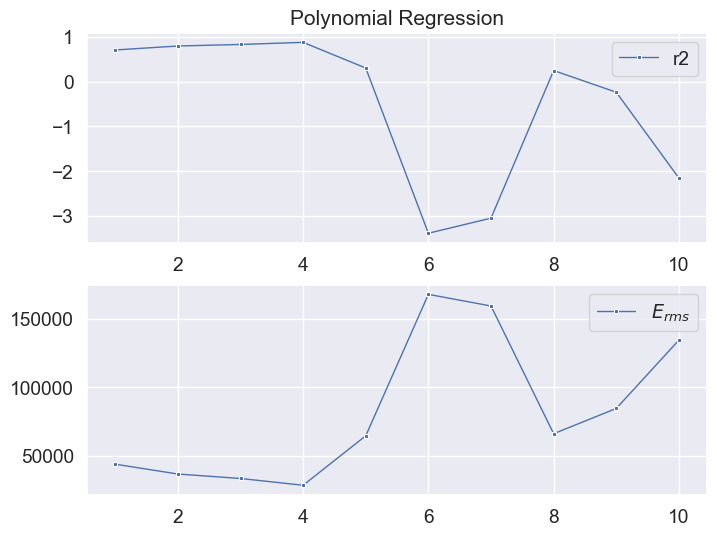

In [53]:
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
simple_plot_scores(x=results["d"], y=results["r2"], label="r2", title="Polynomial Regression")
plt.subplot(2, 1, 2)
simple_plot_scores(x=results["d"], y=results["rms"], label="$E_{rms}$", title="")

### 6.3.3 Performance test

Determiniamo la performance del modello sul testing set, usando il miglior grado:

In [54]:
best_degree = d  # 4
X_poly_train_fs_pca, X_poly_test_fs_pca = polynomial_transformation(X_train_fs_pca, X_test_fs_pca, d=best_degree)
r2_poly_test, rms_poly_test = performance_test(LinearRegression(), dataset, x_train_new=X_poly_train_fs_pca,
                                               x_test_new=X_poly_test_fs_pca, scaled=False)
print(f"Polynomial Regression best degree ({best_degree})-> r2 mean: {r2_poly_test} - rms mean: {rms_poly_test} ")

Polynomial Regression best degree (4)-> r2 mean: 0.787322124704631 - rms mean: 33683.66306263875 


## 6.3 Lasso Regression


### 6.3.1 GridSeach

Tramite GridSearch troviamo il miglior $\alpha$ per la regressiona Lasso:

In [55]:
lasso_regression_gs = Lasso()
params_lasso = {
    'alpha': [1, 5, 50, 100, 300, 500, 1000, 1040, 1100, 1200, 1500, 2000],
    'tol': list(np.linspace(0.1, 1, 10)),
}
r2_gs_lasso, best_param_lasso = grid_search(lasso_regression_gs, dataset, params_lasso, scaled=False)
print(f"Lasso regression -> r2: {r2_gs_lasso} - best parameters: {best_param_lasso}")

Lasso regression -> r2: 0.7576301544209186 - best parameters: {'alpha': 500, 'tol': 0.1}


### 6.3.2 Performance test

Determiniamo la performance del training set tramite cross validation (senza scaling):

In [56]:
lasso_regression = Lasso(alpha=best_param_lasso['alpha'], tol=best_param_lasso['tol'])
r2_cv_lasso, rms_cv_lasso = performance_cross_validation(lasso_regression, dataset)
print(f"Lasso Regression -> r2 = {r2_cv_lasso} rms = {rms_cv_lasso}")

Lasso Regression -> r2 = 0.8436039385999348 rms = 31970.22019466004


Determiniamo la performance del modello sul testing set (senza scaling):

In [57]:
lasso_regression = Lasso(alpha=best_param_lasso['alpha'], tol=best_param_lasso['tol'])
r2_lasso, rms_lasso = performance_test(lasso_regression, dataset)
print(f"Lasso Regression -> r2 mean: {r2_lasso} - rms mean: {rms_lasso} ")

Lasso Regression -> r2 mean: 0.8606626022614583 - rms mean: 27264.152713259675 


### 6.3.3 Performance test con pca, con/senza feature selection

In [58]:
lasso_regression_pca_fs = Lasso(alpha=best_param_lasso['alpha'], tol=best_param_lasso['tol'])

X_train_pca, X_test_pca, X_train_fs_pca, X_test_fs_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=False)
score1_lasso = run_regression_train_test("linear normalized with PCA", lasso_regression_pca_fs, dataset, X_train_pca,
                                   X_test_pca, scaled=False)
score2_lasso = run_regression_train_test("linear normalized with FS and PCA", lasso_regression_pca_fs, dataset,
                                   X_train_fs_pca, X_test_fs_pca, scaled=False)

Feature ridotte da 220 con PCA:  (1168, 4)
Feature selezionate:  (1168, 10)
Feature ridotte da 104 con MI e PCA:  (1168, 4)
linear normalized with PCA - r2: 0.6068601594091201 - rms: 50672.234252160146
linear normalized with PCA - r2 test: 0.6745133814350022 - rms test: 41670.11770857331
linear normalized with FS and PCA - r2: 0.7068936577800589 - rms: 43779.911243127004
linear normalized with FS and PCA - r2 test: 0.7593246233802433 - rms test: 35832.242452974126


## 6.4 Ridge Regression
La ridge regression usa un coefficiente di regolarizzazione $\alpha$ per ridurre la complessità del modello e quindi l'overfitting, il che potrebbe essere utile in quanto abbiamo pochi elementi nel dataset (1480).

### 6.4.1 GridSearch

In [63]:
ridge_regression_gs = Ridge()
params_ridge = {
    #'alpha': list(np.linspace(0.1, 10, 10)),
    'alpha': [1, 20, 50, 100, 110, 139, 170, 200],
    'tol': list(np.linspace(0.1, 1, 10)),
}
r2_gs_ridge, best_param_ridge = grid_search(ridge_regression_gs, dataset, params_ridge)
print(f"Ridge regression -> r2: {r2_gs_ridge} - best parameters: {best_param_ridge}")


Ridge regression -> r2: 0.7862926184880641 - best parameters: {'alpha': 200, 'tol': 0.1}
Ridge regression -> r2: 0.7862926184880641 - best parameters: {'alpha': 200, 'tol': 0.1}
Ridge regression -> r2: 0.7862926184880641 - best parameters: {'alpha': 200, 'tol': 0.1}


### 6.4.2 Perfomance test

In [64]:
ridge_regression = Ridge(alpha=best_param_ridge['alpha'], tol=best_param_ridge['tol'])
r2_cv_ridge, rms_cv_ridge = performance_cross_validation(ridge_regression, dataset)
print(f"Ridge Regression -> r2 = {r2_cv_ridge} rms = {rms_cv_ridge}")


Ridge Regression -> r2 = 0.8377023580768747 rms = 32561.454509829957
Ridge Regression -> r2 = 0.8377023580768747 rms = 32561.454509829957


In [65]:
r2_ridge, rms_ridge = performance_test(ridge_regression, dataset)
print(f"Ridge Regression -> r2 mean: {r2_ridge} - rms mean: {rms_ridge} ")

Ridge Regression -> r2 mean: 0.8601902131611461 - rms mean: 27310.329802940803 
Ridge Regression -> r2 mean: 0.8601902131611461 - rms mean: 27310.329802940803 


La *regressione Ridge* risulta essere migliore della *regressione Lasso*.

### 6.4.3 Performance test con pca, con/senza feature selection

In [72]:
ridge_regression_pca_fs = Lasso(alpha=best_param_ridge['alpha'], tol=best_param_ridge['tol'])

X_train_pca, X_test_pca, X_train_fs_pca, X_test_fs_pca = apply_fs_and_or_pca(dataset, k_fs=10, k_pca=4, scaled=False)
score1_ridge = run_regression_train_test("linear normalized with PCA", ridge_regression_pca_fs, dataset, X_train_pca,
                                   X_test_pca, scaled=False)
score2_ridge = run_regression_train_test("linear normalized with FS and PCA", ridge_regression_pca_fs, dataset,
                                   X_train_fs_pca, X_test_fs_pca, scaled=False)

Feature ridotte da 220 con PCA:  (1168, 4)
Feature selezionate:  (1168, 10)
Feature ridotte da 104 con MI e PCA:  (1168, 4)
linear normalized with PCA - r2: 0.6068601597446204 - rms: 50672.234230505215
linear normalized with PCA - r2 test: 0.6745149582115568 - rms test: 41670.01677578458
linear normalized with FS and PCA - r2: 0.7068937156885904 - rms: 43779.9069154226
linear normalized with FS and PCA - r2 test: 0.7593119297415271 - rms test: 35833.18736796575


# TODO:

## 6.5 ElasticNET Regression

L''Elastic-Net' è un metodo di regressione regolarizzato che combina linearmente le due penalità, *L1* e *L2*, dei metodi di regressione Lasso e Ridge.
- *'l1_ratio'*: determina la percentuale della nostra penalità L1 rispetto a $\alpha$. Quindi, per esempio, se $\alpha = 1$ e $L1_{ratio}$ = 0.4, la nostra penalità $L1$ sarà moltiplicata per 0.4 e la nostra penalità $L2$ sarà moltiplicata per $1 - L1_{ratio} = 0.6$

In questo caso abbiamo la regressione ridge se $L1_{ratio} = 0$ e la regressione lasso se $L1_{ratio} = 1$.

La proprietà più importante di Lasso è che produce pesi del modello sparsi, il che significa che i pesi possono essere impostati fino a 0.



In [86]:
from sklearn.linear_model import ElasticNet, Lasso


def elastic_net_cv(x_train: DataFrame, y_train: Series, alpha=0.1, l1_ratio=0.5, scaled=True) -> Tuple[
    float, float, Any]:
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, tol=0.4, random_state=42)
    val_folds = split_dataset(x_train, y_train, splits=10)
    r2, rms = our_cross_validation(val_folds, model,
                                   scaled=scaled)
    return r2, rms, model


# Esempio con e senza FS / Normalizzazione
r2, rms, _ = elastic_net_cv(folds[0].X_train, folds[0].y_train, scaled=False)
print(f"r2 initial without feature selection - r2: {r2} - mse: {rms}")
r2, rms, _ = elastic_net_cv(fs_X_train, folds[0].y_train, scaled=False)
print(f"r2 initial with feature selection - r2: {r2} - mse: {rms}")
r2, rms, _ = elastic_net_cv(folds[0].X_train_normalized, folds[0].y_train)
print(f"r2 normalized without feature selection - r2: {r2} - mse: {rms}")
r2, rms, _ = elastic_net_cv(fs_X_train_normalized, folds[0].y_train)
print(f"r2 normalized with feature selection - r2: {r2} - mse: {rms}")

r2 initial without feature selection - r2: 0.7109594919379452 - mse: 40311.46325975987
r2 initial with feature selection - r2: 0.7162289134035058 - mse: 40326.77869885859
r2 normalized without feature selection - r2: 0.7260032529974604 - mse: 39293.33515292441
r2 normalized with feature selection - r2: 0.7403388295574751 - mse: 38938.39082861604


Risulta essere migliore il training set con feature selection.

Proviamo a determinare il miglior valore di *alpha* e *l1_ratio* tramite *GridSearch* solo sul fold[0]:

In [54]:
from sklearn.model_selection import GridSearchCV
from numpy import arange, ndarray


def grid_search_elastic_net(folds: List[Fold], k_features=104, with_fs=True):
    param_grid = {
        'alpha': list(np.linspace(0.1, 3, 10)),
        'l1_ratio': arange(0, 1, 0.1),
        'tol': [0.4, 0.5]
    }

    x_train_fs = mutual_info_feature_selection(folds[0].X_train_normalized, folds[0].y_train,
                                               k_features) if with_fs else f.X_train_normalized

    eNet = ElasticNet()

    grid_search = GridSearchCV(eNet, param_grid, scoring='r2', cv=10)
    grid_search.fit(x_train_fs, folds[0].y_train)
    r2_score = grid_search.best_score_
    best_param = grid_search.best_params_
    print(f"ElasticNet alpha = {best_param}  - r2 = {r2_score} ")
    return best_param


best_param_gs_elastic_net = grid_search_elastic_net(folds, k)

ElasticNet alpha = {'alpha': 2.3555555555555556, 'l1_ratio': 0.8, 'tol': 0.5}  - r2 = 0.7872582807065462 


Determiniamo il miglior valore di *alpha* e *l1_ratio*:

In [55]:
def best_param_elastic_net(folds: List[Fold], k_features=104, scaled=True):
    scores = []
    best_alpha = 0
    best_l1 = 0
    best_r2 = 0.0
    alphas = list(np.linspace(0.1, 3, 10))
    l1s = arange(0.1, 1, 0.1)

    # eseguiamo la feature selection su tutti i fold e manteniamola in memoria, per ridurre il tempo di esecuzione totale
    folds = do_fs_for_each_fold(folds, k_features)

    # poi eseguiamo la model selection per trovare il migliore alpha e il miglior L1 ratio
    for a in alphas:
        for l1 in l1s:
            r2_score_cv_sum = 0.0
            rms_score_cv_sum = 0.0
            r2_score_sum = 0.0
            for f in folds:
                r2_score_cv, rms_score_cv, model = elastic_net_cv(f.X_train_normalized_fs, f.y_train, a, l1,
                                                                  scaled=scaled)
                r2_score_cv_sum += r2_score_cv
                rms_score_cv_sum += rms_score_cv
                r2_score_sum += model.score(f.X_test_normalized_fs, f.y_test)
            r2_score_cv = r2_score_cv_sum / len(folds)
            rms_score_cv = rms_score_cv_sum / len(folds)
            r2_score = r2_score_sum / len(folds)
            print(
                f"Elastic net alpha = {a:.4f} - k={k} - l1-ratio = {l1:.1f} r2_cv = {r2_score_cv:.6f} - rms_cv = {rms_score_cv:.6f} - r2 = {r2_score:.6f} ")
            scores.append((a, l1, r2_score, r2_score_cv, rms_score_cv))
            if r2_score > best_r2:
                best_r2 = r2_score
                best_alpha = a
                best_l1 = l1
    scores = pd.DataFrame(scores, columns=['$\\alpha$', "l1-ratio", "$R^2$ test", "$R^2$ train", "rms train"])
    return best_alpha, best_l1, scores


alpha_elastic_net, l1_elastic_net, scores_elastic_net = best_param_elastic_net(folds, k)
#print("ElasticNet without normalization")
#alpha_elastic_net, l1_elastic_net, scores_elastic_net = best_param_elastic_net(folds, k, scaled=False)

Feature selection... Done
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.1 r2_cv = 0.760628 - mse_cv = 1452877365.433158 - r2 = 0.758888 
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.2 r2_cv = 0.758318 - mse_cv = 1466175008.535865 - r2 = 0.756509 
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.3 r2_cv = 0.755890 - mse_cv = 1480174906.525022 - r2 = 0.754008 
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.4 r2_cv = 0.753337 - mse_cv = 1494918841.260780 - r2 = 0.751376 
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.5 r2_cv = 0.750652 - mse_cv = 1510452323.377513 - r2 = 0.748607 
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.6 r2_cv = 0.747825 - mse_cv = 1526823981.225367 - r2 = 0.745690 
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.7 r2_cv = 0.744849 - mse_cv = 1544086876.301473 - r2 = 0.742618 
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.8 r2_cv = 0.741714 - mse_cv = 1562298649.364469 - r2 = 0.739378 
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.9 r2

Best alpha for Elastic net is 0.42222222222222217
Best l1 for Elastic net is 0.2


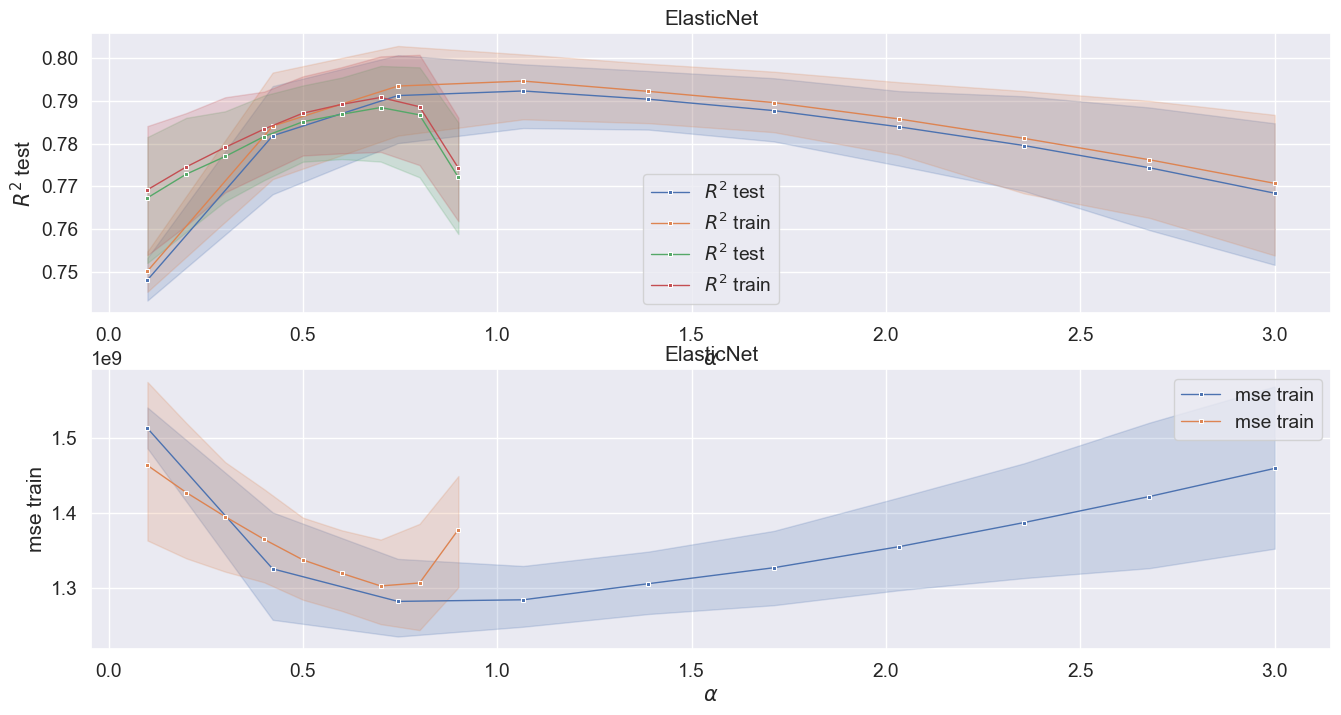

In [56]:
print(f"Best alpha for Elastic net is {alpha_elastic_net}")
print(f"Best l1 for Elastic net is {l1_elastic_net}")
p = BestParameters("ElasticNet", k, alpha_elastic_net, {'l1_ratio': l1_elastic_net}, 0.0, 0.0, scores_elastic_net)
parameters.append(p)

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plot_scores(p.scores, "$\\alpha$", "$R^2$ test")
plot_scores(p.scores, "$\\alpha$", "$R^2$ train")
plot_scores(p.scores, "l1-ratio", "$R^2$ test")
plot_scores(p.scores, "l1-ratio", "$R^2$ train")
plt.subplot(2, 1, 2)
plot_scores(p.scores, "$\\alpha$", "mse train")
plot_scores(p.scores, "l1-ratio", "mse train")

In [57]:
elastic_net = ElasticNet(alpha=alpha_elastic_net, l1_ratio=l1_elastic_net, random_state=42)
mean_r2_elastic_net, mean_rms_elastic_net = our_cross_validation(folds, elastic_net, k)
p.r2 = mean_r2_elastic_net
p.rms = mean_rms_elastic_net
print(f"Lasso -> r2 mean: {mean_r2_elastic_net} - mse mean: {mean_rms_elastic_net}")

Lasso -> r2 mean: 0.8245896004083793 - mse mean: 1097745922.0949037


## 6.6 SVM Regression

Per la regressione SVM, utilizziamo la classe SVR e in particolare selezioniamo i migliori parametri tra i seguenti:

- **Cfloat**: default=1.0. Parametro di regolarizzazione. La forza della regolarizzazione è inversamente proporzionale a C. Deve essere strettamente positivo. La funzione costo è L2.

- **kernel**: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’. Specifica il tipo di funzione kernel da usare nell'algoritmo. 

- **degree**: int, default=3. Grado del polinomio se il kernel è polinomiale. Deve essere non negativo. Viene ignorato da gli altri tipi di kernel diversi da 'poly'.

- **gamma**: {‘scale’, ‘auto’} or float, default=’scale’. Coefficiente Kernel per ‘rbf’, ‘poly’ and ‘sigmoid’.
    - se gamma='scale' (default) $gamma := 1 / (n_{features} * X.var())$,
    - se ‘auto’, $gamma := 1 / n_{features}$
    - se float, $gamma \geq 0$.


In [87]:
from sklearn.model_selection import cross_validate


def svr_cv(X_train: DataFrame, y_train: Series, svm: SVR) -> tuple[Any, ndarray]:
    #return cross_val_score(svm, X_train, y_train, cv=10, scoring='r2', error_score='raise').mean()
    scores = cross_validate(svm, X_train, y_train, cv=10, scoring=('r2', 'neg_mean_squared_error'),
                            return_train_score=True)
    return scores['train_r2'].mean(), np.sqrt(scores['train_neg_mean_squared_error'].mean())


def svr_score(X_train: DataFrame, y_train: Series, X_test: DataFrame, y_test: Series,
              svm: SVR) -> float:
    svm.fit(X_train, y_train)
    return svm.score(X_test, y_test)

In [59]:
# classe per mantenere ordinati i parametri di SVR
class SVRParams:
    def __init__(self, C: float, kernel: str, poly_degree: int, gamma: str | float, max_iter: int) -> None:
        self.C = C
        self.kernel = kernel
        self.poly_degree = poly_degree
        self.gamma = gamma
        self.max_iter = max_iter

    def __str__(self):
        return f"C : {self.C:.2f}, kernel : {self.kernel}, poly_degree : {self.poly_degree}, gamma : {self.gamma:.2f}, max_iter : {self.max_iter}"

    def __repr__(self) -> str:
        return self.__str__()

    def default(self):
        return SVRParams(1, 'rbf', 0, 1, -1)

    def create_svr(self):
        return SVR(C=self.C, kernel=self.kernel, degree=self.poly_degree, gamma=self.gamma, max_iter=self.max_iter,
                   tol=0.01)

    def to_array(self, r2: float, rms: float, r2_test: float):
        return [self.C, self.kernel, self.poly_degree, self.gamma, self.max_iter, r2, rms, r2_test]


In [88]:
def run_svr(params: SVRParams, folds: List[Fold], scores, curr_iter, total_iterations) -> tuple[float, Any]:
    # creo il modello dai parametri scelti (mio metodo di utilita')
    svm = params.create_svr()
    r2_score_cv_sum = 0.0
    rms_score_cv_sum = 0.0
    r2_score_sum = 0.0
    for f in folds:
        # valutazione con cross validation
        r2_score_cv, rms_score_cv = svr_cv(f.X_train_normalized_fs, f.y_train, svm)
        r2_score_cv_sum += r2_score_cv
        rms_score_cv_sum += rms_score_cv
        # valutazione su testing
        r2_score_sum += svr_score(f.X_train_normalized_fs, f.y_train, f.X_test_normalized_fs, f.y_test, svm)
    r2_score_cv = r2_score_cv_sum / len(folds)
    rms_score_cv = rms_score_cv_sum / len(folds)
    r2_score = r2_score_sum / len(folds)

    # aggiungo al dataframe i parametri appena usati e il punteggio.
    new_row_df = pd.DataFrame([params.to_array(r2_score_cv, rms_score_cv, r2_score)],
                              columns=["C", "kernel", "poly_degree", "gamma", 'max_iter', 'r2', 'rms', 'r2_test'])
    scores = pd.concat([scores, new_row_df], axis=0)

    print(
        f"{curr_iter} of {total_iterations} - PARAMS [{params}] - R2: {r2_score_cv:.6f} - rms: {rms_score_cv} -  R2 Test: {r2_score:.6f}")
    return r2_score, scores


# metodo che trova i migliori parametri di SVR
def find_best_svr_params(folds: List[Fold], k_features=129) -> Tuple[pd.DataFrame, Tuple[SVRParams, float]]:
    # questi sono i parametri su cui facciamo grid search
    C_values = [0.1, 0.5, 1, 1.5, 2]
    kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
    poly_degree_values = [2, 3]
    gamma_values = [0.1, 1, 4]
    max_iter = -1  # TODO: non va bene 10000, forse va aggiuta la tol! -1 neanche: sembra non finire mai.

    # assegno i tipi numpy e poi trasformo in dataframe
    dtypes = np.dtype(
        [
            ("C", float),
            ("kernel", str),
            ("poly_degree", int),
            ("gamma", float),
            ('max_iter', int),
            ('r2', float),
            ('rms', float),
            ('r2_test', float)
        ]
    )
    # calcolo il numero di giri da fare in totale:
    total_iterations = (len(C_values) * len(gamma_values)) * (len(poly_degree_values) + len(kernel_values) - 1)
    curr_iter = 0

    # eseguiamo la feature selection su tutti i fold e manteniamola in memoria, per ridurre il tempo di esecuzione totale
    folds = do_fs_for_each_fold(folds, k_features)

    scores: pd.DataFrame[float, str, int, float, int, float, float, float] = pd.DataFrame(np.empty(0, dtype=dtypes))
    best_score_params = {}
    best_r2 = 0.0
    # troviamo i migliori parametri
    for c in C_values:
        for kernel in kernel_values:
            for gamma in gamma_values:
                if kernel == 'poly':
                    for poly_degree in poly_degree_values:
                        curr_iter += 1
                        # metto insieme i parametri nella classe, per comodita'
                        params = SVRParams(c, kernel, poly_degree, gamma, max_iter)
                        r2_score, scores = run_svr(params, folds, scores, curr_iter, total_iterations)
                        if r2_score > best_r2:
                            best_r2 = r2_score
                            best_score_params = (params, r2_score)

                else:
                    curr_iter += 1
                    # metto insieme i parametri nella classe, per comodita'. Il degree e' sempre 0
                    params = SVRParams(c, kernel, 0, gamma, max_iter)
                    r2_score, scores = run_svr(params, folds, scores, curr_iter, total_iterations)
                    if r2_score > best_r2:
                        best_r2 = r2_score
                        best_score_params = {"C": c, "kernel": kernel, "poly_degree": poly_degree, "gamma": gamma,
                                             'max_iter': max_iter}

    return best_score_params, scores

In [61]:
best_score_params_svr, scores_svr = find_best_svr_params(folds)

Feature selection... Done
1 of 75 - PARAMS [C : 0.10, kernel : linear, poly_degree : 0, gamma : 0.10, max_iter : -1] - R2: -0.031321 - mse: -6504100196.855001 -  R2 Test: -0.033796
2 of 75 - PARAMS [C : 0.10, kernel : linear, poly_degree : 0, gamma : 1.00, max_iter : -1] - R2: -0.031321 - mse: -6504100196.855001 -  R2 Test: -0.033796
3 of 75 - PARAMS [C : 0.10, kernel : linear, poly_degree : 0, gamma : 4.00, max_iter : -1] - R2: -0.031321 - mse: -6504100196.855001 -  R2 Test: -0.033796
4 of 75 - PARAMS [C : 0.10, kernel : poly, poly_degree : 2, gamma : 0.10, max_iter : -1] - R2: -0.048538 - mse: -6612670940.724782 -  R2 Test: -0.052702
5 of 75 - PARAMS [C : 0.10, kernel : poly, poly_degree : 3, gamma : 0.10, max_iter : -1] - R2: -0.009848 - mse: -6368395049.630539 -  R2 Test: -0.021226
6 of 75 - PARAMS [C : 0.10, kernel : poly, poly_degree : 2, gamma : 1.00, max_iter : -1] - R2: 0.153693 - mse: -5336759962.914204 -  R2 Test: 0.137708
7 of 75 - PARAMS [C : 0.10, kernel : poly, poly_degr

The BESTEST model is: (C : 0.10, kernel : poly, poly_degree : 3, gamma : 1.00, max_iter : -1, 0.7177767674608109)


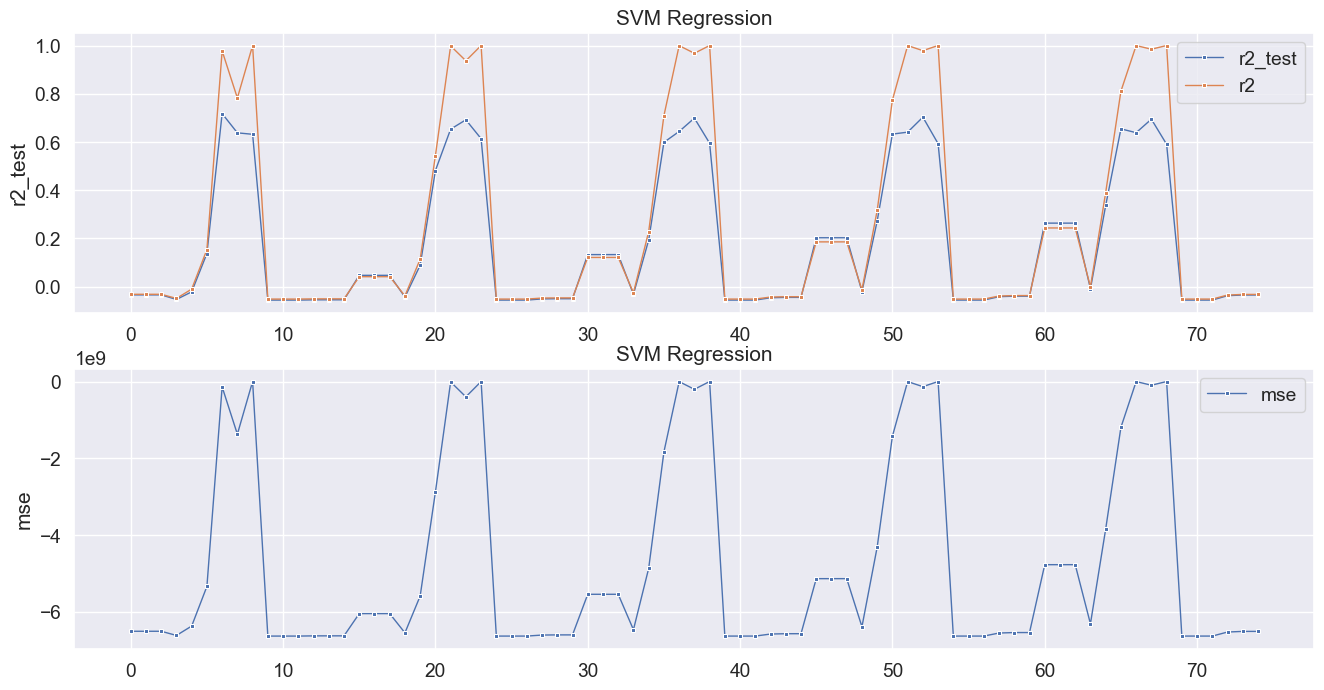

In [62]:
print(f"The BESTEST model is: {best_score_params_svr}")
p = BestParameters("SVM Regression", k, 0.0, best_score_params_svr, 0.0, 0.0, scores_svr)
parameters.append(p)

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plot_scores(p.scores, ["C", "poly_degree", "gamma"], "r2_test")
plot_scores(p.scores, ["C", "poly_degree", "gamma"], "r2")
plt.subplot(2, 1, 2)
plot_scores(p.scores, ["C", "poly_degree", "gamma"], "mse")


## 6.9 KNN
Metodo parametrico.

Dato che stiamo trattando un modello di regressione, prendiamo in considerazione il modello KNeighborsRegressor  basato sul concetto di **"nearest neighbors"**. In pratica, l'algoritmo cerca i K campioni più simili al punto di input di cui vogliamo stimare l'output (ovvero la variabile dipendente) e ne calcola la media.
I parametri sono:
- **n_neighbors**: indica il numero di vicini più vicini per la stima di un punto. Un valore alto porta a una decisione più stabile ma potenzialmente meno accurata. Al contrario, un valore basso di n_neighbors porta a decisioni più flessibili, ma più soggette al rumore nei dati.

- **weights**: indica il peso assegnato a ciascun vicino più prossimo. I possibili valori sono:
  - **'uniform'**, dove tutti i vicini hanno lo stesso peso;
  - **'distance'**, dove il peso di un vicino diminuisce all'aumentare della distanza dal punto di stima.

- **algorithm**: indica l'algoritmo utilizzato per trovare i vicini. I possibili valori sono:
    - **'ball_tree'**, che utilizza un albero di sfere per trovare i vicini più prossimi;
    - **'kd_tree'**, che utilizza un albero KD per trovare i vicini più prossimi;
    - **'brute'**, se il numero di punti è relativamente piccolo,  calcola esplicitamente le distanze tra tutti i punti e seleziona i vicini più prossimi.
- **p**: indica il tipo di distanza.
    - se p=1, utilizza la distanza di Manhattan;
    - se p=2, utilizza la distanza Euclidea;
    - se p arbitrario si utilizza la distanza Minkowski.


In [39]:
from sklearn.neighbors import KNeighborsRegressor


class KNNParams:
    def __init__(self, n_neighbors: int, weights: str, algorithm: str, distance: int) -> None:
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.algorithm = algorithm
        self.distance = distance

    def __str__(self):
        return f"n_neighbors : {self.n_neighbors}, weights : {self.weights}, algorithm : {self.algorithm}, distance: {self.distance}"

    def __repr__(self) -> str:
        return self.__str__()

    def default(self):
        return KNNParams(3, 'uniform', 'brute', 2)

    def create_knn(self):
        return KNeighborsRegressor(n_neighbors=self.n_neighbors, weights=self.weights, algorithm=self.algorithm,
                                   p=self.distance)

    def to_array(self, r2: float, rms: float, r2_test: float):
        return [self.n_neighbors, self.weights, self.algorithm, self.distance, r2, rms, r2_test]

Valutiamo 'KNeighborsRegressor' con training set originale e normalizzato, con feature selection e non.

In [40]:
def knn_cv(x_train: DataFrame, y_train: Series, model: KNeighborsRegressor, scaled=False) -> Tuple[float, float, Any]:
    val_folds = split_dataset(x_train, y_train, splits=10)
    r2, rms = our_cross_validation(val_folds, model,
                                   scaled=scaled)  # non selezioniamo, lo facciamo prima di chiamare questa funzione
    # r2 = cross_val_score(model, x_train, y_train, cv=10, scoring='r2').mean()
    return r2, rms, model


# Esempio con e senza FS / Normalizzazione
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
r2, rms, _ = knn_cv(folds[0].X_train, folds[0].y_train, knn)
print(f"r2 initial without feature selection - r2: {r2} - mse: {rms}")
r2, rms, _ = knn_cv(fs_X_train, folds[0].y_train, knn)
print(f"r2 initial with feature selection - r2: {r2} - mse: {rms}")
r2, rms, _ = knn_cv(folds[0].X_train_normalized, folds[0].y_train, knn, scaled=True)
print(f"r2 normalized without feature selection - r2: {r2} - mse: {rms}")
r2, rms, _ = knn_cv(fs_X_train_normalized, folds[0].y_train, knn, scaled=True)
print(f"r2 normalized with feature selection - r2: {r2} - mse: {rms}")

r2 initial without feature selection - r2: 0.6550919357465242 - mse: 45591.01217390305
r2 initial with feature selection - r2: 0.6635234591200285 - mse: 44232.114847745914
r2 normalized without feature selection - r2: 0.6705239197664363 - mse: 44265.33885643451
r2 normalized with feature selection - r2: 0.7812188060456583 - mse: 35610.038841846115


$r^2$ con training set normalizzato e con feature selection risulta essere il migliore.

Adesso troviamo i migliori parametri per KNN:

In [41]:
def best_parameters_knn(folds: List[Fold], k_features=104, scaled=True):
    best_r2 = 0.0
    scores = pd.DataFrame(
        columns=["n_neighbors", "weights", "algorithm", "distance", '$R^2$ train', 'mse', '$R^2$ test'])
    best_params = {}

    n_neighbors = [3, 5, 7, 9, 11]
    weights = ['uniform', 'distance']
    algorithm = ['ball_tree', 'kd_tree', 'brute']
    distance = [1, 2]  # 1: Manhattan, 2: Euclidean, 3: Minkowski

    folds = do_fs_for_each_fold(folds, k_features)

    for n in n_neighbors:
        for w in weights:
            for a in algorithm:
                for p in distance:
                    r2_score_cv_sum = 0.0
                    rms_score_cv_sum = 0.0
                    r2_score_sum = 0.0
                    for f in folds:
                        knn = KNNParams(n, w, a, p)
                        model = knn.create_knn()
                        r2_score_cv, rms_score_cv, model = knn_cv(f.X_train_normalized_fs, f.y_train, model,
                                                                  scaled=scaled)  # se metti False, il test migl
                        r2_score_cv_sum += r2_score_cv
                        rms_score_cv_sum += rms_score_cv
                        r2_score_sum += model.score(f.X_test_normalized_fs, f.y_test)
                    r2_score_cv = r2_score_cv_sum / len(folds)
                    rms_score_cv = rms_score_cv_sum / len(folds)
                    r2_score = r2_score_sum / len(folds)
                    print(
                        f"KNN  n_neighbors = {n} - weights = {w} - algorithm = {a} - distance = {p} - r2_cv = {r2_score_cv:.6f} - rms = {rms_score_cv:.6f} - r2_test = {r2_score:.6f} ")

                    # aggiungo al dataframe i parametri appena usati e il punteggio.
                    new_row_df = pd.DataFrame([knn.to_array(r2_score_cv, rms_score_cv, r2_score)],
                                              columns=["n_neighbors", "weights", "algorithm", "distance", '$R^2$ train',
                                                       'rms train', '$R^2$ test'])
                    scores = pd.concat([scores, new_row_df], axis=0)

                    if r2_score > best_r2:
                        best_r2 = r2_score
                        best_params = {"n_neighbors": n, "weights": w, "algorithm": a, "distance": p}

    return best_params, scores


best_param_knn, scores_knn = best_parameters_knn(folds)

Feature selection... Done
KNN  n_neighbors = 3 - weights = uniform - algorithm = ball_tree - distance = 1 - r2_cv = 0.736738 - rms = 40555.361158 - r2_test = 0.731137 
KNN  n_neighbors = 3 - weights = uniform - algorithm = ball_tree - distance = 2 - r2_cv = 0.699382 - rms = 43330.417905 - r2_test = 0.685102 
KNN  n_neighbors = 3 - weights = uniform - algorithm = kd_tree - distance = 1 - r2_cv = 0.736738 - rms = 40555.361158 - r2_test = 0.731137 
KNN  n_neighbors = 3 - weights = uniform - algorithm = kd_tree - distance = 2 - r2_cv = 0.699382 - rms = 43330.419200 - r2_test = 0.685102 
KNN  n_neighbors = 3 - weights = uniform - algorithm = brute - distance = 1 - r2_cv = 0.736738 - rms = 40555.361158 - r2_test = 0.731137 
KNN  n_neighbors = 3 - weights = uniform - algorithm = brute - distance = 2 - r2_cv = 0.699382 - rms = 43330.417905 - r2_test = 0.685102 
KNN  n_neighbors = 3 - weights = distance - algorithm = ball_tree - distance = 1 - r2_cv = 0.740308 - rms = 40267.045743 - r2_test = 0

The best parameters are: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'ball_tree', 'distance': 1}


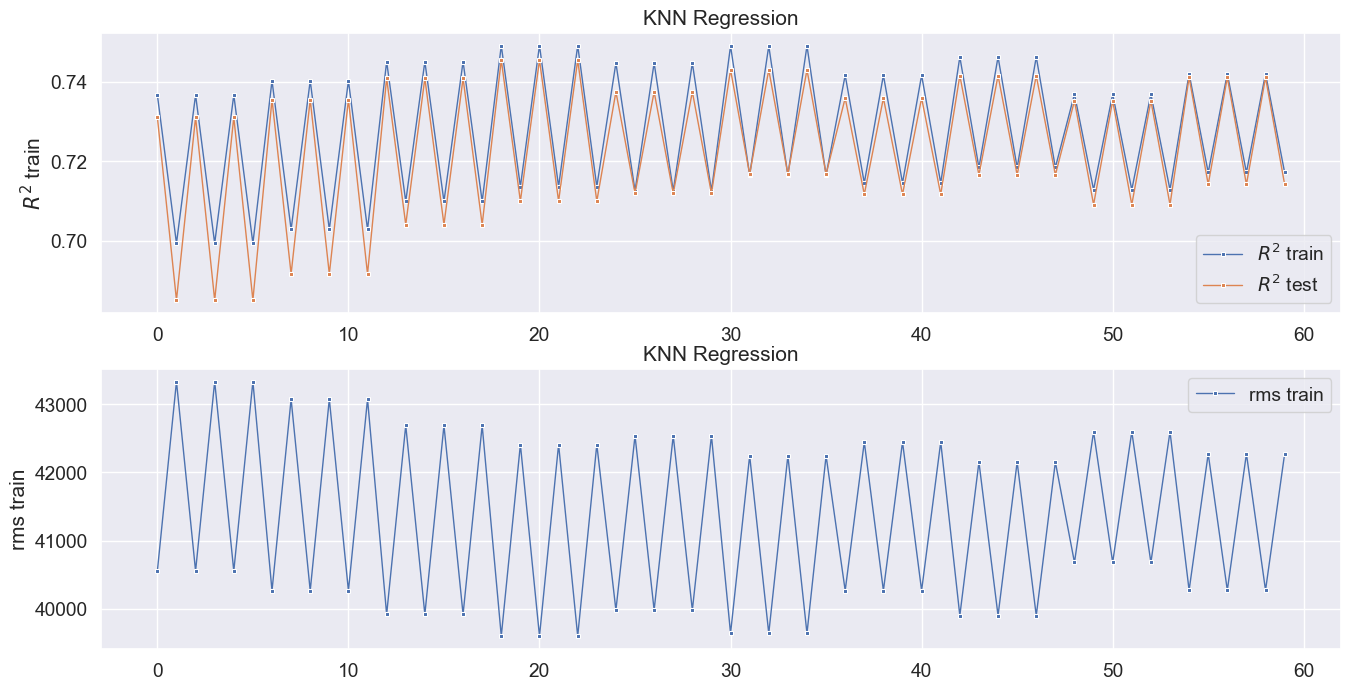

In [44]:
print(f"The best parameters are: {best_param_knn}")
p = BestParameters("KNN Regression", 0, 0.0, best_param_knn, 0.0, 0.0, scores_knn)
parameters.append(p)

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plot_scores(p.scores, "", '$R^2$ train')
plot_scores(p.scores, "", '$R^2$ test')
plt.subplot(2, 1, 2)
plot_scores(p.scores, "", 'rms train')

In [45]:
knn_regression = KNeighborsRegressor(n_neighbors=best_param_knn['n_neighbors'], weights=best_param_knn['weights'],
                                     algorithm=best_param_knn['algorithm'], p=best_param_knn['distance'])
mean_r2_knn, mean_rms_knn = our_cross_validation(folds, knn_regression)
p.r2 = mean_r2_knn
p.rms = mean_rms_knn
print(f"KNN Regression -> r2 mean: {mean_r2_knn} - rms mean: {mean_rms_knn}")

KNN Regression -> r2 mean: 0.723277318801855 - rms mean: 41678.419707793044


## 6.7 Kernel Regression (Nadaraya Watson)
Metodo parametrico

## 6.8 Decision Tree
Metodo parametrico ?

## 6.8 LOESS Regression
Metodo misto parametrico e non.

## 6.10 Reti neurali

# 7. Bagging and Boosting

# 8. Conclusione

In [ ]:
for param in parameters:
    if param.print_parameters() is not None:
        print(param.print_parameters())